# Prep_Results_Sim1
Dieses Notebook lädt die in `Results1/` (oder `CheckResults1/`) abgelegten Simulationsergebnisse
aus **Sim1** und bereitet Tabellen und Graphen auf.

In [20]:
#imports
import os
import glob
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import display, HTML
import math
import textwrap
import warnings
warnings.filterwarnings("ignore", message=".*observed=False is deprecated.*")
pd.options.display.float_format = "{:.2f}".format

## Laden & Aufbereiten (analog R)

In [21]:
RESULTS_DIR = "Results1_neu"        # Basisordner
PREP_DIR = os.path.join(RESULTS_DIR, "Prepared1")
os.makedirs(PREP_DIR, exist_ok=True)
print("Nutze Ergebnisordner:", os.path.abspath(PREP_DIR))

# Szenario-Raster (nur für Ausgabe/Pivots; Dateien werden dynamisch gefunden)
k_vec = [0, 5, 10, 20, 40]
rho_vec = [0.0, 0.5, 0.8]

# Schwelle wie im R-Code (numerische Toleranz)
EPS = 1e-8

def load_all_pickles(results_dir):
    """Lädt alle Pickle-Dateien 'Sim1.k_<k>.rho_<rho>.pkl' aus results_dir."""
    pattern = os.path.join(results_dir, "Sim1.k_*.rho_*.pkl")
    files = sorted(glob.glob(pattern))
    if not files:
        print("Keine Dateien gefunden unter", pattern)
    items = []
    for fn in files:
        try:
            with open(fn, 'rb') as f:
                data = pickle.load(f)
            # Extrahiere k und rho aus Dateinamen zur Sicherheit
            base = os.path.basename(fn)
            # Format: Sim1.k_<k>.rho_<rho>.pkl
            k_str = base.split('k_')[1].split('.rho_')[0]
            rho_str = base.split('rho_')[1].split('.pkl')[0]
            k = int(k_str)
            rho = float(rho_str)
            data['k'] = int(data.get('k', k))
            data['rho'] = float(data.get('rho', rho))
            data['__file__'] = fn
            items.append(data)
        except Exception as e:
            print(f"Fehler beim Laden von {fn}: {e}")
    return items

def as_df_long_diff(diff_mat, method_names, instance_offset, scenario_id, value_name, k, rho):
    """Formt eine (sim_nr x nr_methods)-Matrix in Long-Format; inkl. k & rho."""
    sim_nr, nr_methods = diff_mat.shape
    df = pd.DataFrame(diff_mat, columns=method_names)
    df['instance'] = np.arange(sim_nr) + instance_offset
    df['scenario'] = scenario_id
    long_df = df.melt(id_vars=['instance', 'scenario'], var_name='variable', value_name=value_name)
    long_df['k'] = k
    long_df['rho'] = rho
    return long_df


Nutze Ergebnisordner: /dss/dsshome1/0C/ra96quq2/MA/Results1_neu/Prepared1


## Konfiguration & Helper

In [22]:
all_data = load_all_pickles(RESULTS_DIR)

# Methodenreihenfolge aus allen Blöcken (erste Sichtung gewinnt)
method_order = []
for blk in all_data:
    for m in blk['method_names']:
        if m not in method_order:
            method_order.append(m)

# Container für Aggregationen
df_rows = []
df_mBIC_list = []
df_mBIC2_list = []
df_Runtime_list = []

instance_offset = 0
scenario_id = 0

for block in all_data:
    mBIC_results  = np.asarray(block['mBIC_results'])
    mBIC2_results = np.asarray(block['mBIC2_results'])
    mBIC_FP       = np.asarray(block['mBIC_FP'])
    mBIC2_FP      = np.asarray(block['mBIC2_FP'])
    mBIC_TP       = np.asarray(block['mBIC_TP'])
    mBIC2_TP      = np.asarray(block['mBIC2_TP'])
    runtime       = np.asarray(block['runtime'])
    method_names  = list(block['method_names'])
    k = int(block['k'])
    rho = float(block['rho'])

    sim_nr, nr_methods = mBIC_results.shape

    # Baseline = Methode 0
    stepwise  = mBIC_results[:, [0]]
    stepwise2 = mBIC2_results[:, [0]]

    res  = mBIC_results  - stepwise
    res2 = mBIC2_results - stepwise2

    # NaN-robust: Nur vorhandene Werte werten
    valid_res  = ~np.isnan(res)
    valid_res2 = ~np.isnan(res2)
    
    Worse   = np.sum((res  >  EPS) & valid_res,  axis=0).astype(int)
    Better  = np.sum((res  < -EPS) & valid_res,  axis=0).astype(int)
    Worse2  = np.sum((res2 >  EPS) & valid_res2, axis=0).astype(int)
    Better2 = np.sum((res2 < -EPS) & valid_res2, axis=0).astype(int)

    # NaN-robuste Mittel für FP/TP/Power
    FP = np.nanmean(mBIC_FP, axis=0)
    TP = np.nanmean(mBIC_TP, axis=0)
    Power = (TP / k) if k > 0 else np.zeros_like(TP)

    FP2 = np.nanmean(mBIC2_FP, axis=0)
    TP2 = np.nanmean(mBIC2_TP, axis=0)
    Power2 = (TP2 / k) if k > 0 else np.zeros_like(TP2)

    # FDR2: sim-weise; wenn (FP+TP)==0 -> 0; dann nanmean
    denom = mBIC2_FP + mBIC2_TP
    with np.errstate(divide='ignore', invalid='ignore'):
        fdr2_sim = np.where(denom > 0, mBIC2_FP / denom, 0.0)
    FDR2 = np.nanmean(fdr2_sim, axis=0)

    # NaN-robuste Mittel/SD/SEM
    n_eff_mBIC  = np.sum(valid_res,  axis=0)
    n_eff_mBIC2 = np.sum(valid_res2, axis=0)

    mean_mBIC = np.nanmean(res, axis=0)
    sd_mBIC   = np.nanstd(res, axis=0, ddof=1)
    sem_mBIC  = np.where(n_eff_mBIC  > 0, sd_mBIC  / np.sqrt(n_eff_mBIC),  np.nan)

    mean_mBIC2 = np.nanmean(res2, axis=0)
    sd_mBIC2   = np.nanstd(res2, axis=0, ddof=1)
    sem_mBIC2  = np.where(n_eff_mBIC2 > 0, sd_mBIC2 / np.sqrt(n_eff_mBIC2), np.nan)

    # Runtime nan-robust
    Runtime = np.nanmean(runtime, axis=0)
    # Aggregierte Zeilen pro Methode
    for l, mname in enumerate(method_names):
        df_rows.append({
            'k': k, 'rho': rho, 'method': mname,
            'Better': int(Better[l]), 'Worse': int(Worse[l]),
            'Power': float(Power[l]), 'FP': float(FP[l]),
            'Better2': int(Better2[l]), 'Worse2': int(Worse2[l]),
            'Power2': float(Power2[l]), 'FDR2': float(FDR2[l]),
            'mean_mBIC': float(mean_mBIC[l]), 'sd_mBIC': float(sd_mBIC[l]), 'sem_mBIC': float(sem_mBIC[l]),
            'mean_mBIC2': float(mean_mBIC2[l]), 'sd_mBIC2': float(sd_mBIC2[l]), 'sem_mBIC2': float(sem_mBIC2[l]),
            'Runtime': float(Runtime[l]),
        })

    # Long-Form (Differenzen relativ zur Baseline)
    df_mBIC_list.append(as_df_long_diff(res,  method_names, instance_offset, scenario_id, 'mBIC',  k, rho))
    df_mBIC2_list.append(as_df_long_diff(res2, method_names, instance_offset, scenario_id, 'mBIC2', k, rho))

    # Runtime in Long-Form
    rt_df = pd.DataFrame(runtime, columns=method_names)
    rt_df['instance'] = np.arange(sim_nr) + instance_offset
    rt_df['scenario'] = scenario_id
    runtime_long = rt_df.melt(id_vars=['instance','scenario'], var_name='variable', value_name='Runtime')
    runtime_long['k'] = k
    runtime_long['rho'] = rho
    df_Runtime_list.append(runtime_long)

    # Indizes fortschreiben
    instance_offset += sim_nr
    scenario_id += 1

# --- Nach der Schleife: zusammenbauen und kategorisieren ---

df = pd.DataFrame(df_rows)

df_mBIC   = pd.concat(df_mBIC_list,  ignore_index=True) if df_mBIC_list  else pd.DataFrame(columns=['instance','scenario','variable','mBIC','k','rho'])
df_mBIC2  = pd.concat(df_mBIC2_list, ignore_index=True) if df_mBIC2_list else pd.DataFrame(columns=['instance','scenario','variable','mBIC2','k','rho'])
df_Runtime= pd.concat(df_Runtime_list,ignore_index=True) if df_Runtime_list else pd.DataFrame(columns=['instance','scenario','variable','Runtime','k','rho'])

# Methoden-Reihenfolge setzen
if not df.empty:
    df['method'] = pd.Categorical(df['method'], categories=method_order, ordered=True)

for d in (df_mBIC, df_mBIC2, df_Runtime):
    if not d.empty:
        d['variable'] = pd.Categorical(d['variable'], categories=method_order, ordered=True)
        for col in ['instance','scenario']:
            if col in d.columns:
                d[col] = d[col].astype('category')

print("Fertig geladen. df shape:", df.shape)

Fertig geladen. df shape: (135, 18)


In [23]:
df[df.isna().any(axis=1)]

,k,rho,method,Better,Worse,Power,FP,Better2,Worse2,Power2,FDR2,mean_mBIC,sd_mBIC,sem_mBIC,mean_mBIC2,sd_mBIC2,sem_mBIC2,Runtime


In [24]:
nan_df = pd.DataFrame([{'file':b.get('__file__',''),'k':int(b['k']),'rho':float(b['rho']),
                        'source':src,'method':b['method_names'][j],'sim_idx':int(i)}
                       for b in all_data
                       for src in ['mBIC_results','mBIC2_results','mBIC_FP','mBIC_TP','mBIC2_FP','mBIC2_TP','runtime'] if src in b
                       for j in range(len(b['method_names']))
                       for i in np.where(np.isnan(np.asarray(b[src]))[:, j])[0]])
print(nan_df)

Empty DataFrame
Columns: []
Index: []


## Tabellen

In [25]:
# --- Pivot helper: like R's dcast, drop the 'method' column label ---
def dcast_like(data, value_col, drop_methods=None):
    temp = data.copy()
    if drop_methods is not None and 'method' in temp.columns:
        temp = temp[~temp['method'].isin(drop_methods)]

    pt = temp.pivot_table(index=['k','rho'], columns='method',
                          values=value_col, aggfunc='first').reset_index()
    pt.columns.name = None  # remove "method" column label
    cols = ['k','rho'] + [c for c in pt.columns if c not in ('k','rho')]
    return pt[cols]

# --- Build tables ---
drop_stepwise = ['stepwise_plain']

tab_Better   = dcast_like(df, 'Better',  drop_methods=drop_stepwise)
tab_Better2  = dcast_like(df, 'Better2', drop_methods=drop_stepwise)
tab_Worse    = dcast_like(df, 'Worse',   drop_methods=drop_stepwise)
tab_Worse2   = dcast_like(df, 'Worse2',  drop_methods=drop_stepwise)
tabFP        = dcast_like(df, 'FP')
tabFDR2      = dcast_like(df, 'FDR2')

# Power tables only for k > 0
df_posk   = df[df['k'] > 0] if not df.empty else df
tabPower  = dcast_like(df_posk, 'Power')
tabPower2 = dcast_like(df_posk, 'Power2')

tab_m       = dcast_like(df, 'mean_mBIC')
tabsem      = dcast_like(df, 'sem_mBIC')
tab_m2      = dcast_like(df, 'mean_mBIC2')
tabsem2     = dcast_like(df, 'sem_mBIC2')
tab_runtime = dcast_like(df, 'Runtime')

In [26]:
# Unified display helper
def _display_tbl(name, tbl):
    if tbl is None:
        return
    try:
        if hasattr(tbl, "empty") and tbl.empty:
            display(HTML(f"<h3 style='margin: 1.25em 0 0.5em 0'>{name}</h3><p><em>(no data)</em></p>"))
            return
    except Exception:
        pass
    display(HTML(f"<h3 style='margin: 1.25em 0 0.5em 0'>{name}</h3>"))
    try:
        show(tbl)
    except Exception:
        display(tbl)

tables = [
    ("Total number of improvements (mBIC)",   tab_Better),
    ("Total number of improvements (mBIC2)",  tab_Better2),
    ("Total number of worsenings (mBIC)",    tab_Worse),
    ("Total number of worsenings (mBIC2)",   tab_Worse2),
    ("Average False Positives (mBIC)",       tabFP),
    ("FDR (mBIC2)",     tabFDR2),
    ("Power (mBIC)",    tabPower),
    ("Power (mBIC2)",   tabPower2),
    ("Mean difference (mBIC)",   tab_m),
    ("SEM of difference (mBIC)",    tabsem),
    ("Mean difference (mBIC2)",  tab_m2),
    ("SEM of difference (mBIC2)",   tabsem2),
    ("Average runtime",     tab_runtime),
]

for name, tbl in tables:
    _display_tbl(name, tbl)

,k,rho,stepwise_reduced,stepwise_ff,L0opt_CD,L0opt_CDPSI,lassonet,lassonet_plus,deep2stage,deep2stage_plus
0,0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
1,0,0.50,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
2,0,0.80,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
3,5,0.00,0.00,1.00,1.00,1.00,0.00,0.00,0.00,0.00
4,5,0.50,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
5,5,0.80,0.00,1.00,1.00,1.00,0.00,0.00,0.00,1.00
6,10,0.00,0.00,1.00,1.00,1.00,1.00,0.00,1.00,1.00
7,10,0.50,0.00,4.00,4.00,4.00,2.00,2.00,2.00,2.00
8,10,0.80,1.00,5.00,1.00,11.00,1.00,6.00,0.00,9.00
9,20,0.00,0.00,1.00,1.00,1.00,1.00,0.00,1.00,1.00


,k,rho,stepwise_reduced,stepwise_ff,L0opt_CD,L0opt_CDPSI,lassonet,lassonet_plus,deep2stage,deep2stage_plus
0,0,0.00,0.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00
1,0,0.50,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
2,0,0.80,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
3,5,0.00,0.00,3.00,3.00,4.00,1.00,1.00,0.00,2.00
4,5,0.50,0.00,2.00,2.00,2.00,1.00,0.00,0.00,0.00
5,5,0.80,0.00,3.00,3.00,4.00,1.00,1.00,0.00,1.00
6,10,0.00,0.00,12.00,12.00,12.00,3.00,0.00,5.00,6.00
7,10,0.50,0.00,12.00,11.00,12.00,1.00,2.00,1.00,2.00
8,10,0.80,1.00,7.00,5.00,15.00,0.00,5.00,0.00,8.00
9,20,0.00,0.00,38.00,36.00,37.00,1.00,1.00,5.00,11.00


,k,rho,stepwise_reduced,stepwise_ff,L0opt_CD,L0opt_CDPSI,lassonet,lassonet_plus,deep2stage,deep2stage_plus
0,0,0.00,0.00,1.00,0.00,0.00,0.00,0.00,11.00,0.00
1,0,0.50,0.00,0.00,0.00,0.00,0.00,0.00,10.00,0.00
2,0,0.80,0.00,1.00,0.00,0.00,0.00,0.00,9.00,0.00
3,5,0.00,36.00,0.00,0.00,0.00,10.00,0.00,43.00,0.00
4,5,0.50,49.00,2.00,1.00,1.00,11.00,0.00,93.00,0.00
5,5,0.80,57.00,26.00,5.00,3.00,113.00,5.00,302.00,2.00
6,10,0.00,188.00,1.00,0.00,0.00,46.00,1.00,54.00,0.00
7,10,0.50,189.00,4.00,0.00,0.00,54.00,0.00,111.00,1.00
8,10,0.80,213.00,63.00,14.00,11.00,281.00,60.00,402.00,5.00
9,20,0.00,437.00,8.00,0.00,0.00,138.00,139.00,309.00,0.00


,k,rho,stepwise_reduced,stepwise_ff,L0opt_CD,L0opt_CDPSI,lassonet,lassonet_plus,deep2stage,deep2stage_plus
0,0,0.00,0.00,2.00,0.00,0.00,0.00,0.00,11.00,0.00
1,0,0.50,0.00,2.00,0.00,0.00,0.00,0.00,10.00,0.00
2,0,0.80,0.00,2.00,0.00,0.00,0.00,0.00,9.00,0.00
3,5,0.00,85.00,4.00,0.00,0.00,46.00,0.00,111.00,0.00
4,5,0.50,88.00,9.00,0.00,0.00,58.00,0.00,170.00,0.00
5,5,0.80,87.00,49.00,12.00,10.00,171.00,7.00,344.00,10.00
6,10,0.00,274.00,22.00,0.00,0.00,156.00,4.00,185.00,6.00
7,10,0.50,273.00,19.00,5.00,5.00,168.00,8.00,229.00,4.00
8,10,0.80,282.00,106.00,31.00,21.00,376.00,94.00,445.00,20.00
9,20,0.00,478.00,39.00,1.00,1.00,387.00,241.00,418.00,12.00


,k,rho,stepwise_plain,stepwise_reduced,stepwise_ff,L0opt_CD,L0opt_CDPSI,lassonet,lassonet_plus,deep2stage,deep2stage_plus
0,0,0.00,0.03,0.03,0.03,0.03,0.03,0.03,0.03,0.01,0.03
1,0,0.50,0.03,0.03,0.03,0.03,0.03,0.03,0.03,0.00,0.03
2,0,0.80,0.02,0.02,0.03,0.02,0.02,0.02,0.02,0.00,0.02
3,5,0.00,0.03,0.02,0.03,0.03,0.03,0.02,0.03,0.03,0.03
4,5,0.50,0.04,0.03,0.04,0.04,0.04,0.03,0.04,0.04,0.04
5,5,0.80,0.09,0.10,0.12,0.09,0.08,0.12,0.09,0.52,0.09
6,10,0.00,0.05,0.02,0.05,0.05,0.05,0.04,0.05,0.05,0.05
7,10,0.50,0.06,0.06,0.07,0.06,0.06,0.06,0.06,0.08,0.06
8,10,0.80,0.16,0.28,0.22,0.17,0.16,0.41,0.23,1.00,0.16
9,20,0.00,0.06,0.02,0.07,0.06,0.06,0.09,0.04,0.07,0.06


,k,rho,stepwise_plain,stepwise_reduced,stepwise_ff,L0opt_CD,L0opt_CDPSI,lassonet,lassonet_plus,deep2stage,deep2stage_plus
0,0,0.00,0.03,0.03,0.03,0.03,0.03,0.03,0.03,0.01,0.03
1,0,0.50,0.02,0.02,0.03,0.02,0.02,0.02,0.02,0.00,0.02
2,0,0.80,0.02,0.02,0.03,0.02,0.02,0.02,0.02,0.00,0.02
3,5,0.00,0.04,0.03,0.05,0.05,0.05,0.04,0.05,0.03,0.05
4,5,0.50,0.04,0.03,0.04,0.04,0.04,0.03,0.04,0.02,0.04
5,5,0.80,0.05,0.04,0.06,0.05,0.05,0.04,0.05,0.11,0.05
6,10,0.00,0.05,0.02,0.06,0.06,0.06,0.04,0.05,0.04,0.06
7,10,0.50,0.04,0.02,0.05,0.05,0.05,0.03,0.04,0.03,0.04
8,10,0.80,0.05,0.06,0.07,0.06,0.06,0.06,0.07,0.13,0.06
9,20,0.00,0.06,0.02,0.07,0.06,0.06,0.03,0.03,0.04,0.06


,k,rho,stepwise_plain,stepwise_reduced,stepwise_ff,L0opt_CD,L0opt_CDPSI,lassonet,lassonet_plus,deep2stage,deep2stage_plus
0,5,0.00,0.86,0.84,0.86,0.86,0.86,0.85,0.86,0.84,0.86
1,5,0.50,0.85,0.84,0.85,0.85,0.85,0.85,0.85,0.83,0.85
2,5,0.80,0.84,0.82,0.84,0.84,0.85,0.82,0.84,0.77,0.85
3,10,0.00,0.85,0.81,0.86,0.86,0.86,0.85,0.85,0.85,0.86
4,10,0.50,0.86,0.81,0.86,0.86,0.86,0.85,0.86,0.84,0.86
5,10,0.80,0.84,0.79,0.83,0.84,0.84,0.80,0.84,0.78,0.84
6,20,0.00,0.85,0.75,0.85,0.85,0.85,0.84,0.83,0.85,0.85
7,20,0.50,0.84,0.73,0.84,0.84,0.84,0.82,0.79,0.84,0.84
8,20,0.80,0.84,0.73,0.83,0.83,0.84,0.76,0.70,0.78,0.84
9,40,0.00,0.85,0.65,0.85,0.85,0.85,0.82,0.60,0.84,0.85


,k,rho,stepwise_plain,stepwise_reduced,stepwise_ff,L0opt_CD,L0opt_CDPSI,lassonet,lassonet_plus,deep2stage,deep2stage_plus
0,5,0.00,0.87,0.85,0.87,0.87,0.87,0.87,0.87,0.85,0.87
1,5,0.50,0.87,0.85,0.87,0.87,0.87,0.87,0.87,0.84,0.87
2,5,0.80,0.85,0.83,0.85,0.85,0.85,0.83,0.85,0.79,0.85
3,10,0.00,0.88,0.82,0.88,0.88,0.88,0.87,0.88,0.87,0.88
4,10,0.50,0.88,0.82,0.88,0.88,0.88,0.87,0.88,0.86,0.88
5,10,0.80,0.86,0.80,0.85,0.86,0.86,0.81,0.86,0.80,0.86
6,20,0.00,0.88,0.76,0.88,0.88,0.88,0.86,0.85,0.87,0.88
7,20,0.50,0.87,0.75,0.87,0.87,0.87,0.84,0.84,0.86,0.87
8,20,0.80,0.85,0.74,0.84,0.85,0.86,0.78,0.79,0.80,0.86
9,40,0.00,0.89,0.67,0.89,0.89,0.89,0.83,0.66,0.87,0.89


,k,rho,stepwise_plain,stepwise_reduced,stepwise_ff,L0opt_CD,L0opt_CDPSI,lassonet,lassonet_plus,deep2stage,deep2stage_plus
0,0,0.00,0.00,0.00,0.00,0.00,0.00,-0.00,-0.00,0.03,-0.00
1,0,0.50,0.00,0.00,0.00,0.00,0.00,-0.00,-0.00,0.04,-0.00
2,0,0.80,0.00,0.00,0.01,0.00,0.00,0.00,-0.00,0.03,-0.00
3,5,0.00,0.00,0.79,-0.00,-0.00,-0.00,0.04,-0.00,0.44,-0.00
4,5,0.50,0.00,1.59,0.01,0.00,0.00,0.03,-0.00,1.46,-0.00
5,5,0.80,0.00,2.20,0.10,-0.00,-0.02,1.71,0.01,12.71,-0.02
6,10,0.00,0.00,10.78,-0.00,-0.00,-0.00,0.21,0.00,0.15,-0.00
7,10,0.50,0.00,11.66,-0.01,-0.04,-0.04,0.38,-0.03,1.41,-0.02
8,10,0.80,0.00,14.72,0.55,0.13,0.01,9.42,1.03,23.01,-0.04
9,20,0.00,0.00,73.32,0.01,-0.01,-0.01,1.46,7.22,0.25,-0.01


,k,rho,stepwise_plain,stepwise_reduced,stepwise_ff,L0opt_CD,L0opt_CDPSI,lassonet,lassonet_plus,deep2stage,deep2stage_plus
0,0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.01,0.00
1,0,0.50,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.02,0.00
2,0,0.80,0.00,0.00,0.01,0.00,0.00,0.00,0.00,0.01,0.00
3,5,0.00,0.00,0.18,0.00,0.00,0.00,0.02,0.00,0.10,0.00
4,5,0.50,0.00,0.33,0.01,0.00,0.00,0.01,0.00,0.19,0.00
5,5,0.80,0.00,0.49,0.05,0.04,0.04,0.20,0.01,0.68,0.04
6,10,0.00,0.00,1.03,0.00,0.00,0.00,0.04,0.00,0.04,0.00
7,10,0.50,0.00,1.19,0.04,0.03,0.03,0.08,0.03,0.20,0.03
8,10,0.80,0.00,1.40,0.10,0.04,0.04,0.75,0.27,0.91,0.03
9,20,0.00,0.00,3.21,0.01,0.01,0.01,0.16,0.86,0.05,0.01


,k,rho,stepwise_plain,stepwise_reduced,stepwise_ff,L0opt_CD,L0opt_CDPSI,lassonet,lassonet_plus,deep2stage,deep2stage_plus
0,0,0.00,0.00,0.00,0.00,-0.00,-0.00,-0.00,-0.00,0.03,-0.00
1,0,0.50,0.00,0.00,0.04,0.00,0.00,-0.00,-0.00,0.04,-0.00
2,0,0.80,0.00,0.00,0.04,0.00,0.00,0.00,-0.00,0.03,-0.00
3,5,0.00,0.00,1.16,0.06,-0.00,-0.00,0.14,-0.00,0.74,-0.00
4,5,0.50,0.00,2.05,0.02,-0.00,-0.00,0.17,-0.00,1.96,-0.00
5,5,0.80,0.00,2.62,0.29,0.04,0.03,2.06,0.01,12.23,0.04
6,10,0.00,0.00,13.60,0.04,-0.03,-0.03,0.72,0.01,0.67,-0.00
7,10,0.50,0.00,14.37,0.03,-0.03,-0.03,1.00,0.01,2.24,-0.01
8,10,0.80,0.00,16.79,0.85,0.20,0.07,10.40,0.59,21.41,0.04
9,20,0.00,0.00,87.70,0.02,-0.07,-0.07,4.14,7.13,1.46,-0.01


,k,rho,stepwise_plain,stepwise_reduced,stepwise_ff,L0opt_CD,L0opt_CDPSI,lassonet,lassonet_plus,deep2stage,deep2stage_plus
0,0,0.00,0.00,0.00,0.01,0.00,0.00,0.00,0.00,0.01,0.00
1,0,0.50,0.00,0.00,0.03,0.00,0.00,0.00,0.00,0.02,0.00
2,0,0.80,0.00,0.00,0.03,0.00,0.00,0.00,0.00,0.01,0.00
3,5,0.00,0.00,0.21,0.05,0.00,0.00,0.03,0.00,0.11,0.00
4,5,0.50,0.00,0.36,0.01,0.00,0.00,0.03,0.00,0.20,0.00
5,5,0.80,0.00,0.51,0.05,0.02,0.02,0.20,0.01,0.60,0.02
6,10,0.00,0.00,1.13,0.02,0.01,0.01,0.07,0.00,0.07,0.01
7,10,0.50,0.00,1.27,0.03,0.02,0.02,0.09,0.01,0.20,0.01
8,10,0.80,0.00,1.45,0.10,0.05,0.04,0.72,0.08,0.76,0.02
9,20,0.00,0.00,3.47,0.03,0.01,0.01,0.24,0.75,0.09,0.01


,k,rho,stepwise_plain,stepwise_reduced,stepwise_ff,L0opt_CD,L0opt_CDPSI,lassonet,lassonet_plus,deep2stage,deep2stage_plus
0,0,0.00,0.26,0.10,0.59,0.14,1.41,6.37,7.81,1.73,2.69
1,0,0.50,0.29,0.12,0.71,0.20,2.04,6.51,8.67,3.04,4.11
2,0,0.80,0.29,0.11,0.61,0.21,2.46,6.71,7.35,3.32,4.33
3,5,0.00,1.49,0.30,0.71,0.17,1.64,7.18,9.99,1.75,4.63
4,5,0.50,1.34,0.28,0.62,0.15,1.47,7.67,9.96,1.67,4.24
5,5,0.80,1.53,0.40,0.75,0.23,2.49,7.46,13.44,2.06,5.93
6,10,0.00,2.55,0.45,0.72,0.16,1.51,6.87,26.01,27.09,27.54
7,10,0.50,3.14,0.64,0.99,0.23,2.15,6.89,16.20,2.25,9.03
8,10,0.80,3.04,0.76,0.97,0.24,2.51,6.84,20.29,1.83,8.60
9,20,0.00,7.17,1.09,1.49,0.25,2.29,7.15,18.75,2.10,10.86


## Results stratified by factors

In [27]:
# Plots for number of improvements/worsening depending on k and rho

def plot_stepwise_comparison(df, metric='mBIC', kind='improvements', ymax=100):
    """
    metric: 'mBIC' or 'mBIC2'
    kind:   'improvements' (Better/Better2) or 'worsenings' (Worse/Worse2)
    ymax:   y axix maximum
    """
    metric = metric.lower()
    kind = kind.lower()
    if metric not in ('mbic', 'mbic2'):
        raise ValueError("metric must be 'mBIC' or 'mBIC2'")
    if kind not in ('improvements', 'worsenings'):
        raise ValueError("kind must be 'improvements' or 'worsenings'")

    col_map = {
        'mbic':  {'improvements': 'Better',  'worsenings': 'Worse'},
        'mbic2': {'improvements': 'Better2', 'worsenings': 'Worse2'}
    }
    col = col_map[metric][kind]

    agg = (df.groupby(['rho', 'k', 'method'])[col].sum().reset_index())
    rhos = sorted(agg['rho'].unique())
    methods = [m for m in method_order if m in agg['method'].unique()]

    # Styles:
    colors = {
        'stepwise_plain': 'black',
        'stepwise_reduced': 'black',
        'stepwise_ff': 'black',
        'L0opt_CD': 'blue',
        'L0opt_CDPSI': 'blue',
        'GSDAR': 'limegreen',
        'lassonet': 'orange',
        'lassonet_plus': 'orange',
        'deep2stage': 'magenta',
        'deep2stage_plus': 'magenta'
    }
    linestyles = {
        'stepwise_plain': '-',
        'stepwise_reduced': '--',
        'stepwise_ff': ':',
        'L0opt_CD': '-',
        'L0opt_CDPSI': ':',
        'GSDAR': '-',
        'lassonet': '-',
        'lassonet_plus': ':',
        'deep2stage': '-',
        'deep2stage_plus': ':'
    }

    nrows = max(1, len(rhos))
    fig, axes = plt.subplots(nrows, 1, sharex=True, sharey=True,
                             figsize=(9, 9), constrained_layout=True)
    axes = np.atleast_1d(axes)

    for ax, r in zip(axes, rhos):
        sub = agg[agg['rho'] == r]
        for m in methods:
            s = sub[sub['method'] == m]
            if s.empty:
                continue
            ax.plot(
                s['k'], s[col],
                label=m, linewidth=2,
                linestyle=linestyles.get(m, '-'),
                color=colors.get(m, None)
            )
        ax.set_title(f"ρ = {r}")
        ax.grid(True, alpha=0.3)

    # x axis
    axes[-1].set_xlabel("k")
    xticks = [0, 5, 10, 20, 40]
    axes[-1].set_xticks(xticks)
    xmin = min(0, agg["k"].min())
    xmax = max(40, agg["k"].max())
    axes[-1].set_xlim(xmin, xmax)


    # y axis
    for ax in fig.axes:
        ax.set_ylim(0, ymax)
        ax.set_yticks(np.linspace(0, ymax, 4, dtype=int))
        ax.set_ylabel("")

    # legend
    handles, labels = axes[-1].get_legend_handles_labels()
    by_label = {lab: h for h, lab in zip(handles, labels)}
    fig.legend(by_label.values(), by_label.keys(),
               loc='center left', bbox_to_anchor=(1.01, 0.5), title="method")
    
    #title
    title_kind = "Number of improvements" if kind == 'improvements' else "Number of worsenings"
    label = 'mBIC' if metric == 'mbic' else 'mBIC2'

    # y axis
    y_label = f"{title_kind} ({label})"
    for ax in fig.axes:
        ax.set_ylim(0, ymax)
        ax.set_yticks(np.linspace(0, ymax, 4, dtype=int))
        ax.set_ylabel("")
    fig.supylabel(y_label, x=-0.04)
    #fig.suptitle(f"{label}: {title_kind} over stepwise", y=1.02)
    
    plt.show()

,k,stepwise_plain,stepwise_reduced,stepwise_ff,L0opt_CD,L0opt_CDPSI,lassonet,lassonet_plus,deep2stage,deep2stage_plus
0,0,0,0,0,0,0,0,0,0,0
1,5,0,0,2,2,2,0,0,0,1
2,10,0,1,10,6,16,4,8,3,12
3,20,0,0,31,16,45,3,3,8,44
4,40,0,0,66,58,110,0,0,11,100


,k,stepwise_plain,stepwise_reduced,stepwise_ff,L0opt_CD,L0opt_CDPSI,lassonet,lassonet_plus,deep2stage,deep2stage_plus
0,0,0,0,1,1,1,1,1,1,1
1,5,0,0,8,8,10,3,2,0,3
2,10,0,1,31,28,39,4,7,6,16
3,20,0,0,96,82,137,2,12,10,78
4,40,0,0,133,226,306,0,0,3,159


,rho,stepwise_plain,stepwise_reduced,stepwise_ff,L0opt_CD,L0opt_CDPSI,lassonet,lassonet_plus,deep2stage,deep2stage_plus
0,0.00,0,0,5,9,9,2,0,2,3
1,0.50,0,0,21,17,22,3,2,7,15
2,0.80,0,1,83,56,142,2,9,13,139


,rho,stepwise_plain,stepwise_reduced,stepwise_ff,L0opt_CD,L0opt_CDPSI,lassonet,lassonet_plus,deep2stage,deep2stage_plus
0,0.00,0,0,94,156,159,6,3,13,52
1,0.50,0,0,89,121,137,3,4,5,70
2,0.80,0,1,86,68,197,1,15,2,135


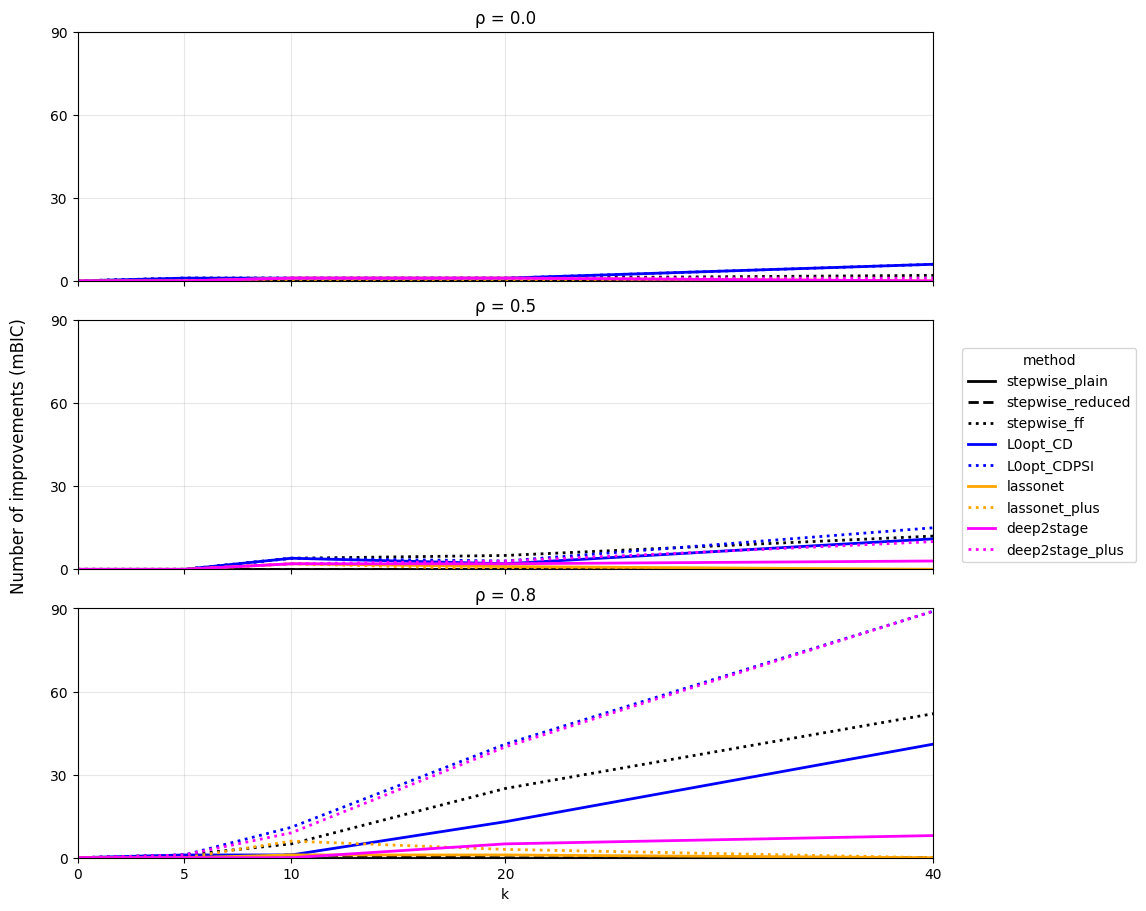

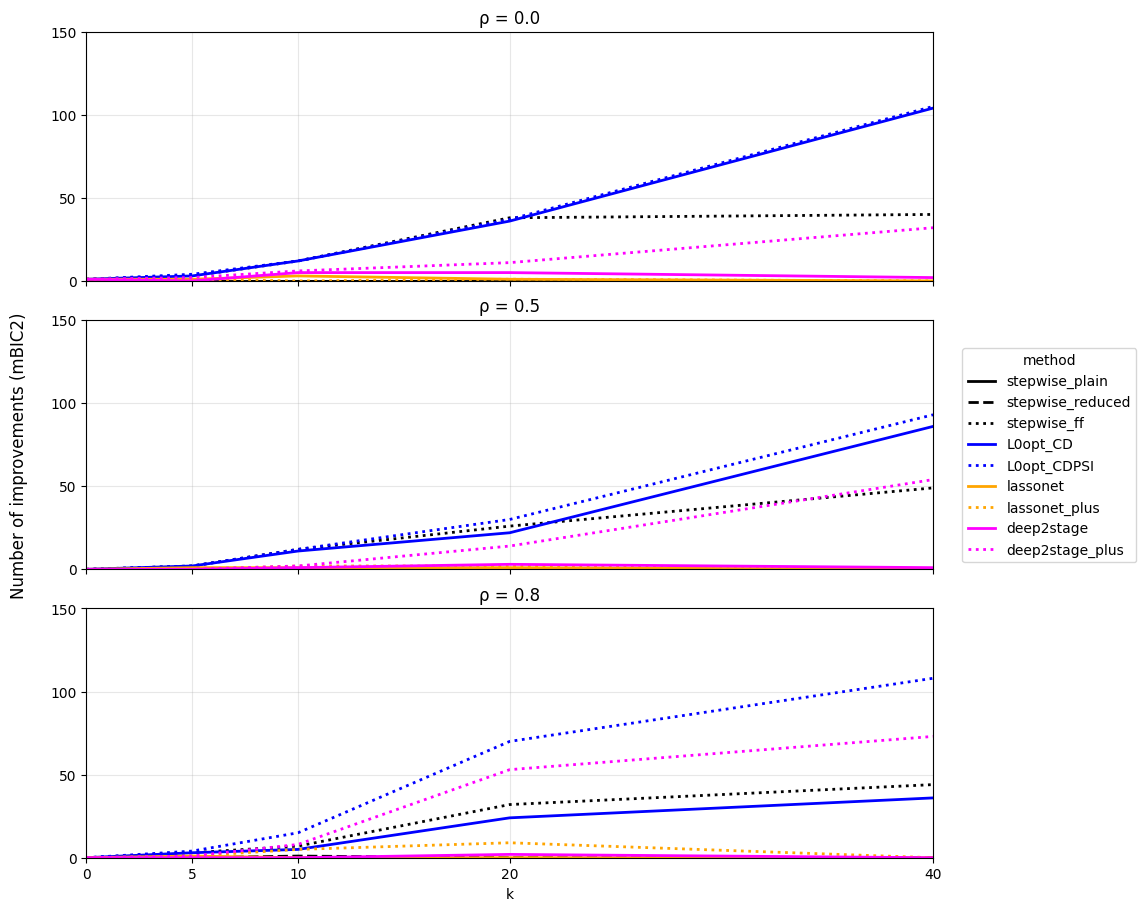

In [28]:
def _improv_tables(df, value_col, index_col):
    col_order = [m for m in method_order if m in df['method'].unique()]
    g = (df.groupby([index_col, 'method'])[value_col]
           .sum()
           .reset_index())
    pt = g.pivot(index=index_col, columns='method', values=value_col).reset_index()
    pt.columns.name = None
    cols = [index_col] + [m for m in col_order if m in pt.columns]
    return pt[cols]
    
# Tables for each k / rho summarized - Improvements
tab_impr_k_mBIC  = _improv_tables(df, 'Better',  'k')
tab_impr_k_mBIC2 = _improv_tables(df, 'Better2', 'k')
tab_impr_rho_mBIC  = _improv_tables(df, 'Better',  'rho')
tab_impr_rho_mBIC2 = _improv_tables(df, 'Better2', 'rho')

_display_tbl("Number of Improvements by k (mBIC)",   tab_impr_k_mBIC)
_display_tbl("Number of Improvements by k (mBIC2)",  tab_impr_k_mBIC2)
_display_tbl("Number of Improvements by rho (mBIC)", tab_impr_rho_mBIC)
_display_tbl("Number of Improvements by rho (mBIC2)",tab_impr_rho_mBIC2)

# Plots - Improvements
plot_stepwise_comparison(df, metric='mBIC',  kind='improvements', ymax=90)
plot_stepwise_comparison(df, metric='mBIC2', kind='improvements', ymax=150)

,k,stepwise_plain,stepwise_reduced,stepwise_ff,L0opt_CD,L0opt_CDPSI,lassonet,lassonet_plus,deep2stage,deep2stage_plus
0,0,0,0,2,0,0,0,0,30,0
1,5,0,142,28,6,4,134,5,438,2
2,10,0,590,68,14,11,381,61,567,6
3,20,0,1325,177,67,46,836,807,1093,27
4,40,0,1499,273,289,180,1403,1498,1488,151


,k,stepwise_plain,stepwise_reduced,stepwise_ff,L0opt_CD,L0opt_CDPSI,lassonet,lassonet_plus,deep2stage,deep2stage_plus
0,0,0,0,6,0,0,0,0,30,0
1,5,0,260,62,12,10,275,7,625,10
2,10,0,829,147,36,26,700,106,859,30
3,20,0,1430,306,131,103,1280,912,1321,102
4,40,0,1500,439,489,371,1496,1498,1497,436


,rho,stepwise_plain,stepwise_reduced,stepwise_ff,L0opt_CD,L0opt_CDPSI,lassonet,lassonet_plus,deep2stage,deep2stage_plus
0,0.00,0,1161,21,3,3,621,638,916,7
1,0.50,0,1178,36,20,19,760,743,1019,16
2,0.80,0,1217,491,353,219,1373,990,1681,163


,rho,stepwise_plain,stepwise_reduced,stepwise_ff,L0opt_CD,L0opt_CDPSI,lassonet,lassonet_plus,deep2stage,deep2stage_plus
0,0.00,0,1337,121,29,29,1086,743,1223,80
1,0.50,0,1339,168,121,116,1121,788,1320,109
2,0.80,0,1343,671,518,365,1544,992,1789,389


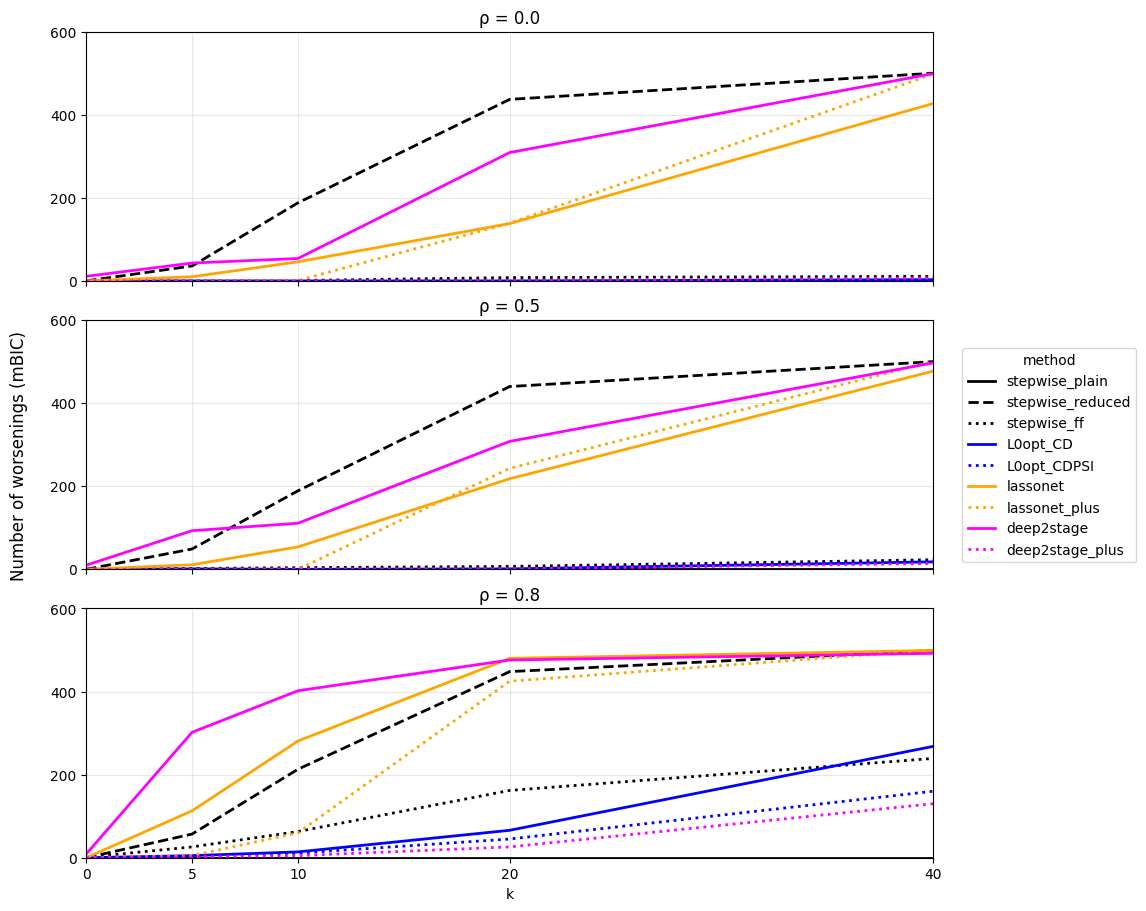

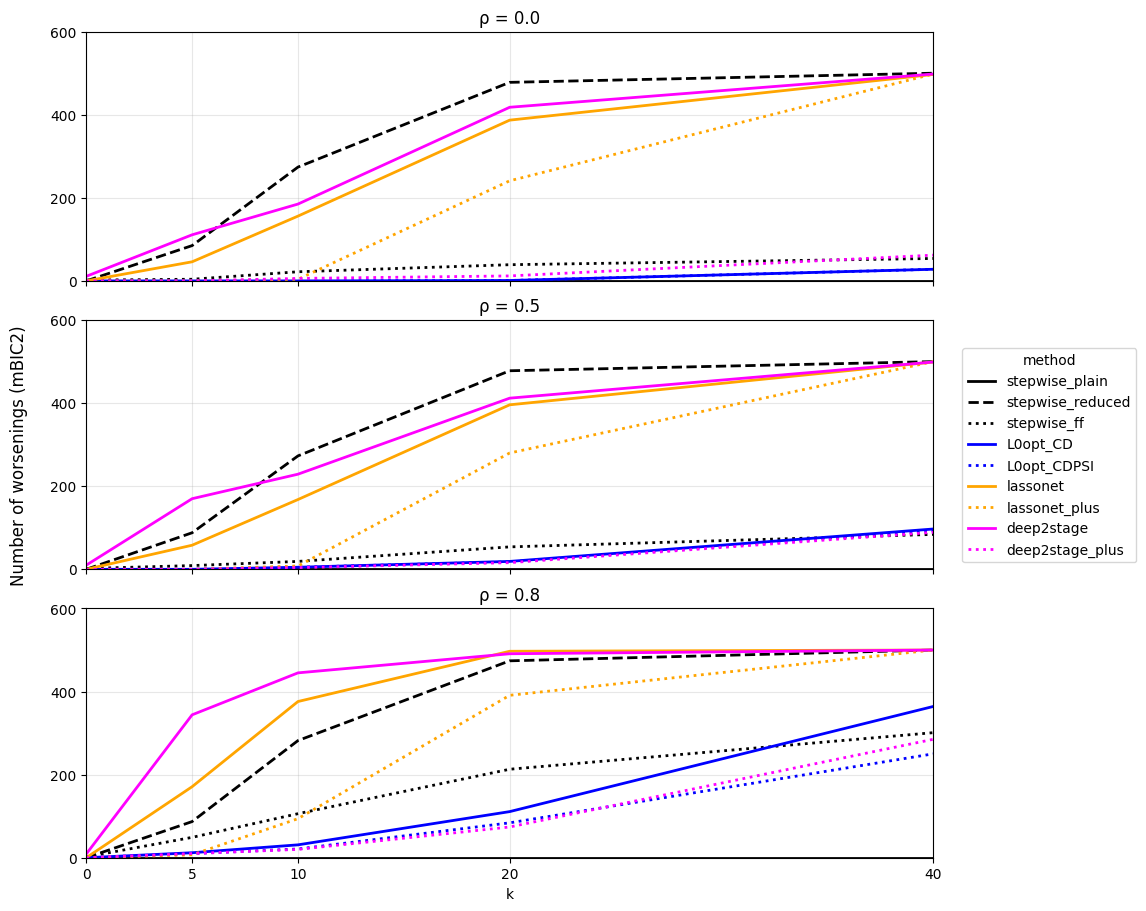

In [29]:
# ============================ Pivot & Anzeige ============================

def _count_table(df, value_col, index_col):
    col_order = [m for m in method_order if m in df['method'].unique()]
    g = (df.groupby([index_col, 'method'])[value_col]
           .sum()
           .reset_index())
    pt = g.pivot(index=index_col, columns='method', values=value_col).reset_index()
    pt.columns.name = None
    cols = [index_col] + [m for m in col_order if m in pt.columns]
    return pt[cols]

# Tables for each k / rho summarized - Worsenings
tab_worse_k_mBIC   = _count_table(df, 'Worse',  'k')
tab_worse_k_mBIC2  = _count_table(df, 'Worse2', 'k')
tab_worse_rho_mBIC  = _count_table(df, 'Worse',  'rho')
tab_worse_rho_mBIC2 = _count_table(df, 'Worse2', 'rho')

_display_tbl("Number of Worsenings by k (mBIC)",    tab_worse_k_mBIC)
_display_tbl("Number of Worsenings by k (mBIC2)",   tab_worse_k_mBIC2)
_display_tbl("Number of Worsenings by rho (mBIC)",  tab_worse_rho_mBIC)
_display_tbl("Number of Worsenings by rho (mBIC2)", tab_worse_rho_mBIC2)

plot_stepwise_comparison(df, metric='mBIC',  kind='worsenings', ymax=600)
plot_stepwise_comparison(df, metric='mBIC2', kind='worsenings', ymax=600)

In [30]:
# ============================ Pivot & Anzeige ============================

def _avg_table(df, value_col, index_col):
    """Mittelt den Kennwert je (index_col, method) und pivotiert breit."""
    col_order = [m for m in method_order if m in df['method'].unique()]
    g = (df.groupby([index_col, 'method'])[value_col]
           .mean()
           .reset_index())
    pt = g.pivot(index=index_col, columns='method', values=value_col).reset_index()
    pt.columns.name = None
    cols = [index_col] + [m for m in col_order if m in pt.columns]

    float_cols = pt.select_dtypes(include='float').columns
    pt[float_cols] = pt[float_cols].round(2)
    return pt[cols]

# =======================
# Tables
# =======================

# 1) False Positives (mBIC)
tab_fp_k   = _avg_table(df, "FP",  "k")
tab_fp_rho = _avg_table(df, "FP",  "rho")
_display_tbl("Average Number of FP by k (mBIC)",   tab_fp_k)
_display_tbl("Average Number of FP by rho (mBIC)", tab_fp_rho)

# 2) False Discovery Rate (mBIC2)  -> FDR2 in df
tab_fdr_k   = _avg_table(df, 'FDR2', 'k')
tab_fdr_rho = _avg_table(df, 'FDR2', 'rho')
_display_tbl("FDR by k (mBIC2)",   tab_fdr_k)
_display_tbl("FDR by rho (mBIC2)", tab_fdr_rho)

# 3) Power (beide) -> nur k>0
df_posk = df[df['k'] > 0]
tab_power_k_mBIC   = _avg_table(df_posk, 'Power',  'k')
tab_power_rho_mBIC = _avg_table(df_posk, 'Power',  'rho')
tab_power_k_mBIC2   = _avg_table(df_posk, 'Power2', 'k')
tab_power_rho_mBIC2 = _avg_table(df_posk, 'Power2', 'rho')
_display_tbl("Power by k (mBIC)",    tab_power_k_mBIC)
_display_tbl("Power by rho (mBIC)",  tab_power_rho_mBIC)
_display_tbl("Power by k (mBIC2)",   tab_power_k_mBIC2)
_display_tbl("Power by rho (mBIC2)", tab_power_rho_mBIC2)

# 4) Runtime (beide – identisch inhaltlich, aber der Übersicht halber getrennt ausgewiesen)
tab_runtime_k_mBIC   = _avg_table(df, 'Runtime', 'k')
tab_runtime_rho_mBIC = _avg_table(df, 'Runtime', 'rho')
tab_runtime_k_mBIC2   = _avg_table(df, 'Runtime', 'k')
tab_runtime_rho_mBIC2 = _avg_table(df, 'Runtime', 'rho')
_display_tbl("Runtime by k (mBIC)",    tab_runtime_k_mBIC)
_display_tbl("Runtime by rho (mBIC)",  tab_runtime_rho_mBIC)
_display_tbl("Runtime by k (mBIC2)",   tab_runtime_k_mBIC2)
_display_tbl("Runtime by rho (mBIC2)", tab_runtime_rho_mBIC2)

# =======================
# Plot-Funktion im bekannten Stil
# =======================
def plot_metric_over_k(df, which='mBIC', metric='FP', ymax=None):
    """
    Zeichnet Linienplots (facets=ρ, x=k) für die gewünschten Kennzahlen.
    which:  'mBIC' oder 'mBIC2'
    metric: 'FP' (nur mBIC), 'FDR' (nur mBIC2), 'Power', 'Runtime'
    ymax:   gemeinsames y-Limit (None = automatisch)
    """
    w = which.lower()
    m = metric.lower()

    # Spaltenzuordnung
    if m == 'fp':
        if w != 'mbic':
            raise ValueError("FP ist nur für mBIC definiert.")
        value_col = 'FP'
        title_metric = 'Average Number of FP'
    elif m == 'fdr':
        if w != 'mbic2':
            raise ValueError("FDR ist nur für mBIC2 definiert.")
        value_col = 'FDR2'
        title_metric = 'FDR'
    elif m == 'power':
        value_col = 'Power' if w == 'mbic' else 'Power2'
        title_metric = 'Power'
    elif m == 'runtime':
        value_col = 'Runtime'  # identisch für beide
        title_metric = 'Runtime'
    else:
        raise ValueError("metric muss 'FP', 'FDR', 'Power' oder 'Runtime' sein.")

    # ggf. auf k>0 für Power filtern
    data = df if value_col != 'Power' and value_col != 'Power2' else df[df['k'] > 0]

    # Aggregation (falls mehrere Blöcke pro (rho,k,method) existieren -> Mittel)
    agg = (data.groupby(['rho', 'k', 'method'])[value_col]
                 .mean()
                 .reset_index())

    rhos = sorted(agg['rho'].unique())
    methods = [m for m in method_order if m in agg['method'].unique()]

    # Styles (deine Vorgaben)
    colors = {
        'stepwise_plain': 'black',
        'stepwise_reduced': 'black',
        'stepwise_ff': 'black',
        'L0opt_CD': 'blue',
        'L0opt_CDPSI': 'blue',
        'GSDAR': 'red',
        'lassonet': 'orange',
        'lassonet_plus': 'orange',
        'deep2stage': 'magenta',
        'deep2stage_plus': 'magenta'
        
    }
    linestyles = {
        'stepwise_plain': '-',
        'stepwise_reduced': '--',
        'stepwise_ff': ':',
        'L0opt_CD': '-',
        'L0opt_CDPSI': ':',
        'GSDAR': '-',
        'lassonet': '-',
        'lassonet_plus': ':',
        'deep2stage': '-',
        'deep2stage_plus': ':'
    }

    nrows = max(1, len(rhos))
    fig, axes = plt.subplots(nrows, 1, sharex=True, sharey=True,
                             figsize=(9, 9), constrained_layout=True)
    axes = np.atleast_1d(axes)

    for ax, r in zip(axes, rhos):
        sub = agg[agg['rho'] == r]
        for meth in methods:
            s = sub[sub['method'] == meth]
            if s.empty:
                continue
            ax.plot(s['k'], s[value_col],
                    label=meth, linewidth=2,
                    linestyle=linestyles.get(meth, '-'),
                    color=colors.get(meth, None))
        ax.set_title(f"ρ = {r}")
        ax.grid(True, alpha=0.3)

    # x axis
    axes[-1].set_xlabel("k")
    if value_col in ('Power', 'Power2'):
        xmin = 5
        xticks = [5, 10, 20, 40]
    else:
        xmin = min(0, agg["k"].min())
        xticks = [0, 5, 10, 20, 40]

    xmax = max(40, agg["k"].max())
    axes[-1].set_xlim(xmin, xmax)
    axes[-1].set_xticks([t for t in xticks if xmin <= t <= xmax])

    label = 'mBIC' if w == 'mbic' else 'mBIC2'
    if value_col == 'Runtime':
        y_label = 'Runtime (in seconds)'        
    else:
        label = 'mBIC' if w == 'mbic' else 'mBIC2'
        y_label = f"{title_metric} ({label})"


    # y axis
    fig.supylabel(y_label, x=-0.04)
    if ymax is not None:
        for ax in fig.axes:
            ax.set_ylim(0, ymax)
            ax.set_yticks(np.linspace(0, ymax, 6))
            ax.set_ylabel("")
    else:
        for ax in fig.axes:
            ax.set_ylabel("")

    #fig.suptitle(f"{label}: {title_metric}", y=1.02)

    # Legende (Duplikate vermeiden)
    handles, labels = axes[-1].get_legend_handles_labels()
    by_label = {lab: h for h, lab in zip(handles, labels)}
    fig.legend(by_label.values(), by_label.keys(),
               loc='center left', bbox_to_anchor=(1.01, 0.5), title="method")

    plt.show()

,k,stepwise_plain,stepwise_reduced,stepwise_ff,L0opt_CD,L0opt_CDPSI,lassonet,lassonet_plus,deep2stage,deep2stage_plus
0,0,0.03,0.03,0.03,0.03,0.03,0.03,0.03,0.00,0.03
1,5,0.05,0.05,0.07,0.05,0.05,0.06,0.06,0.20,0.06
2,10,0.09,0.12,0.11,0.09,0.09,0.17,0.11,0.38,0.09
3,20,0.16,0.37,0.25,0.18,0.16,0.63,0.11,0.59,0.16
4,40,0.31,0.86,0.46,0.46,0.32,2.72,0.10,0.99,0.30


,rho,stepwise_plain,stepwise_reduced,stepwise_ff,L0opt_CD,L0opt_CDPSI,lassonet,lassonet_plus,deep2stage,deep2stage_plus
0,0.00,0.05,0.02,0.05,0.05,0.05,0.13,0.03,0.05,0.05
1,0.50,0.07,0.18,0.07,0.07,0.07,0.29,0.03,0.08,0.07
2,0.80,0.27,0.66,0.42,0.37,0.27,1.74,0.18,1.17,0.26


,k,stepwise_plain,stepwise_reduced,stepwise_ff,L0opt_CD,L0opt_CDPSI,lassonet,lassonet_plus,deep2stage,deep2stage_plus
0,0,0.02,0.02,0.03,0.03,0.03,0.03,0.03,0.01,0.03
1,5,0.04,0.03,0.05,0.05,0.05,0.04,0.05,0.06,0.05
2,10,0.05,0.03,0.06,0.05,0.05,0.04,0.06,0.07,0.05
3,20,0.06,0.05,0.07,0.06,0.06,0.06,0.03,0.07,0.06
4,40,0.07,0.07,0.08,0.09,0.09,0.12,0.01,0.08,0.07


,rho,stepwise_plain,stepwise_reduced,stepwise_ff,L0opt_CD,L0opt_CDPSI,lassonet,lassonet_plus,deep2stage,deep2stage_plus
0,0.00,0.05,0.02,0.06,0.06,0.06,0.04,0.03,0.03,0.05
1,0.50,0.05,0.03,0.05,0.05,0.05,0.03,0.03,0.03,0.05
2,0.80,0.05,0.07,0.07,0.06,0.06,0.10,0.04,0.10,0.05


,k,stepwise_plain,stepwise_reduced,stepwise_ff,L0opt_CD,L0opt_CDPSI,lassonet,lassonet_plus,deep2stage,deep2stage_plus
0,5,0.85,0.83,0.85,0.85,0.85,0.84,0.85,0.81,0.85
1,10,0.85,0.80,0.85,0.85,0.85,0.83,0.85,0.83,0.85
2,20,0.84,0.74,0.84,0.84,0.84,0.81,0.77,0.82,0.84
3,40,0.83,0.63,0.83,0.83,0.84,0.77,0.50,0.80,0.84


,rho,stepwise_plain,stepwise_reduced,stepwise_ff,L0opt_CD,L0opt_CDPSI,lassonet,lassonet_plus,deep2stage,deep2stage_plus
0,0.00,0.85,0.76,0.85,0.85,0.85,0.84,0.78,0.85,0.85
1,0.50,0.85,0.75,0.85,0.85,0.85,0.83,0.76,0.83,0.85
2,0.80,0.83,0.74,0.82,0.83,0.83,0.77,0.69,0.77,0.83


,k,stepwise_plain,stepwise_reduced,stepwise_ff,L0opt_CD,L0opt_CDPSI,lassonet,lassonet_plus,deep2stage,deep2stage_plus
0,5,0.86,0.84,0.86,0.86,0.86,0.85,0.86,0.83,0.86
1,10,0.87,0.81,0.87,0.87,0.87,0.85,0.87,0.84,0.87
2,20,0.87,0.75,0.87,0.87,0.87,0.83,0.83,0.84,0.87
3,40,0.87,0.65,0.87,0.87,0.87,0.79,0.60,0.84,0.87


,rho,stepwise_plain,stepwise_reduced,stepwise_ff,L0opt_CD,L0opt_CDPSI,lassonet,lassonet_plus,deep2stage,deep2stage_plus
0,0.00,0.88,0.77,0.88,0.88,0.88,0.86,0.81,0.87,0.88
1,0.50,0.87,0.77,0.88,0.88,0.88,0.85,0.80,0.85,0.87
2,0.80,0.85,0.75,0.84,0.85,0.85,0.78,0.76,0.79,0.85


,k,stepwise_plain,stepwise_reduced,stepwise_ff,L0opt_CD,L0opt_CDPSI,lassonet,lassonet_plus,deep2stage,deep2stage_plus
0,0,0.28,0.11,0.64,0.18,1.97,6.53,7.94,2.69,3.71
1,5,1.45,0.33,0.69,0.18,1.86,7.44,11.13,1.83,4.93
2,10,2.91,0.62,0.89,0.21,2.06,6.87,20.83,10.39,15.06
3,20,6.86,1.34,1.67,0.25,2.40,8.39,20.19,1.88,10.58
4,40,18.77,3.17,6.48,0.30,2.66,7.31,22.13,1.86,14.72


,rho,stepwise_plain,stepwise_reduced,stepwise_ff,L0opt_CD,L0opt_CDPSI,lassonet,lassonet_plus,deep2stage,deep2stage_plus
0,0.00,6.02,0.85,1.54,0.20,1.88,7.04,16.66,6.89,11.89
1,0.50,6.05,1.01,1.83,0.22,2.10,7.53,15.34,2.17,8.57
2,0.80,6.10,1.48,2.85,0.25,2.58,7.35,17.33,2.13,8.93


,k,stepwise_plain,stepwise_reduced,stepwise_ff,L0opt_CD,L0opt_CDPSI,lassonet,lassonet_plus,deep2stage,deep2stage_plus
0,0,0.28,0.11,0.64,0.18,1.97,6.53,7.94,2.69,3.71
1,5,1.45,0.33,0.69,0.18,1.86,7.44,11.13,1.83,4.93
2,10,2.91,0.62,0.89,0.21,2.06,6.87,20.83,10.39,15.06
3,20,6.86,1.34,1.67,0.25,2.40,8.39,20.19,1.88,10.58
4,40,18.77,3.17,6.48,0.30,2.66,7.31,22.13,1.86,14.72


,rho,stepwise_plain,stepwise_reduced,stepwise_ff,L0opt_CD,L0opt_CDPSI,lassonet,lassonet_plus,deep2stage,deep2stage_plus
0,0.00,6.02,0.85,1.54,0.20,1.88,7.04,16.66,6.89,11.89
1,0.50,6.05,1.01,1.83,0.22,2.10,7.53,15.34,2.17,8.57
2,0.80,6.10,1.48,2.85,0.25,2.58,7.35,17.33,2.13,8.93


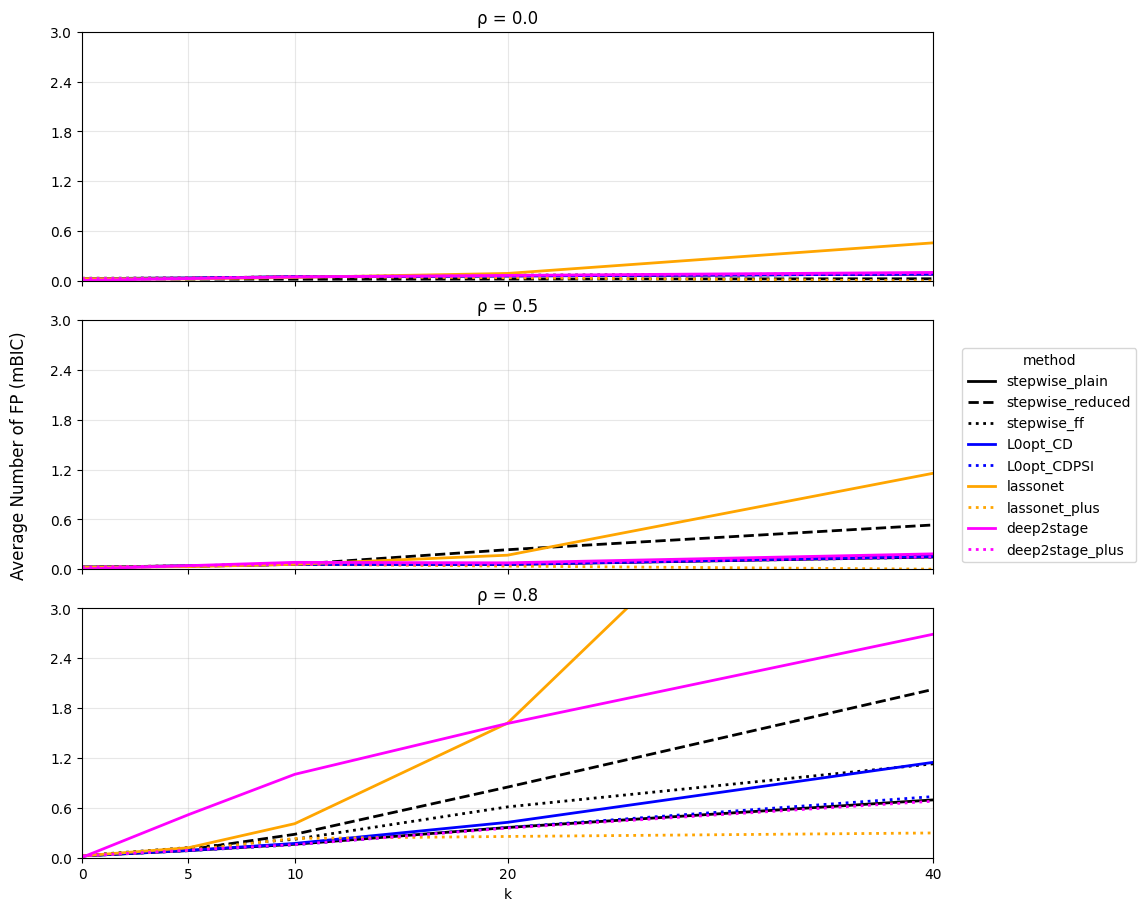

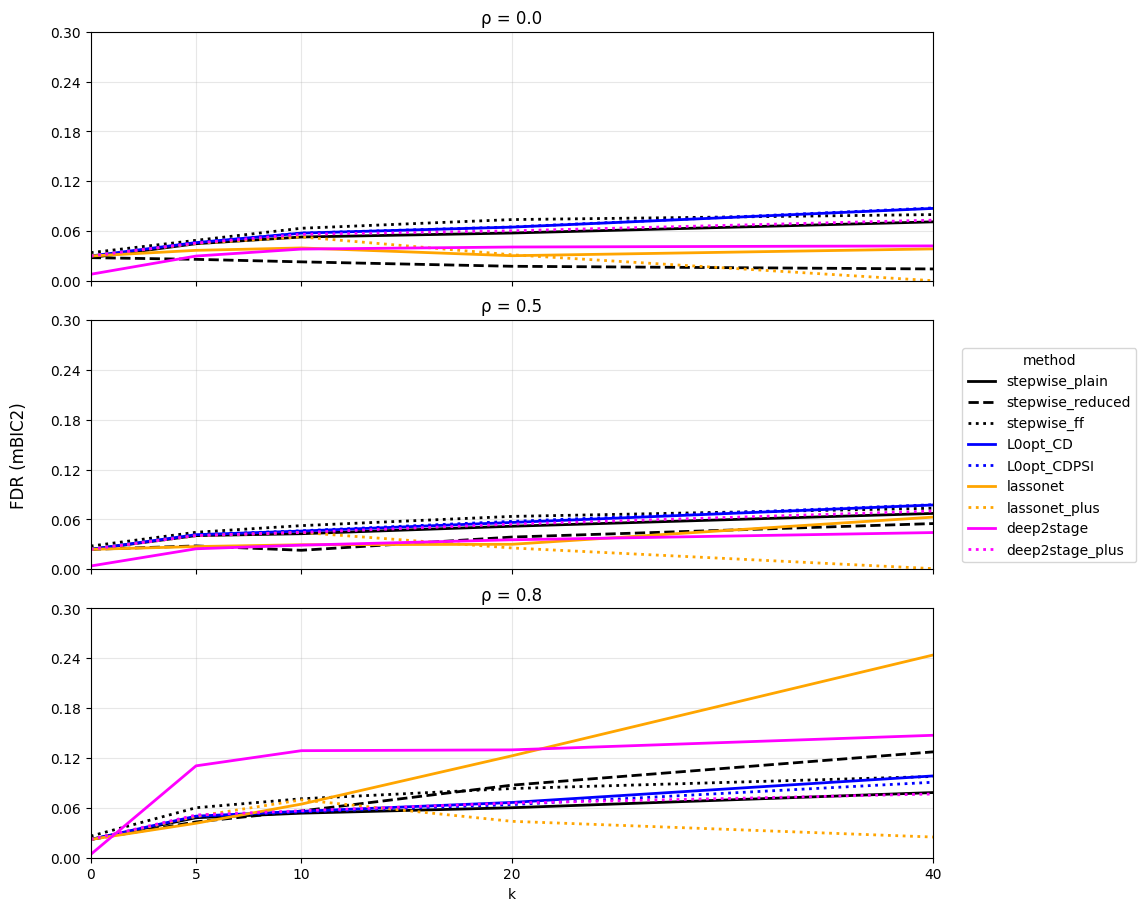

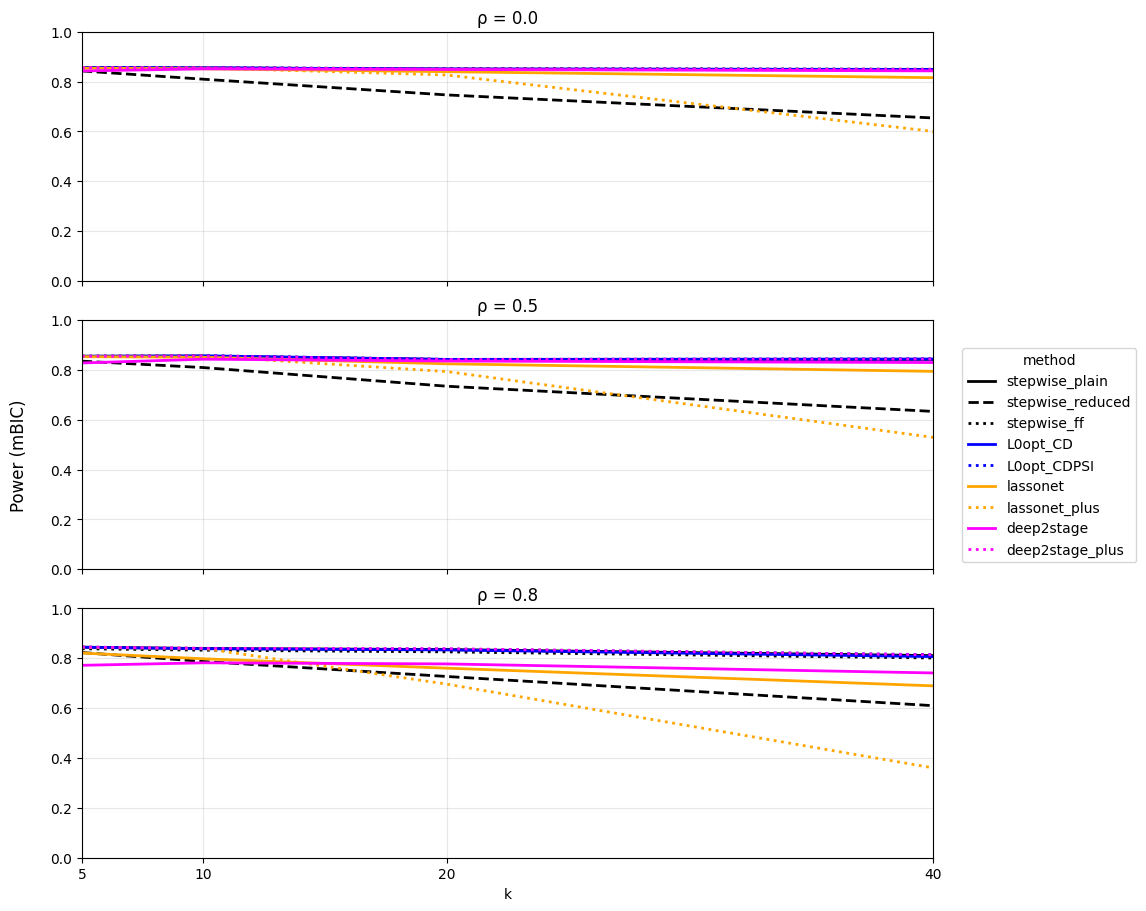

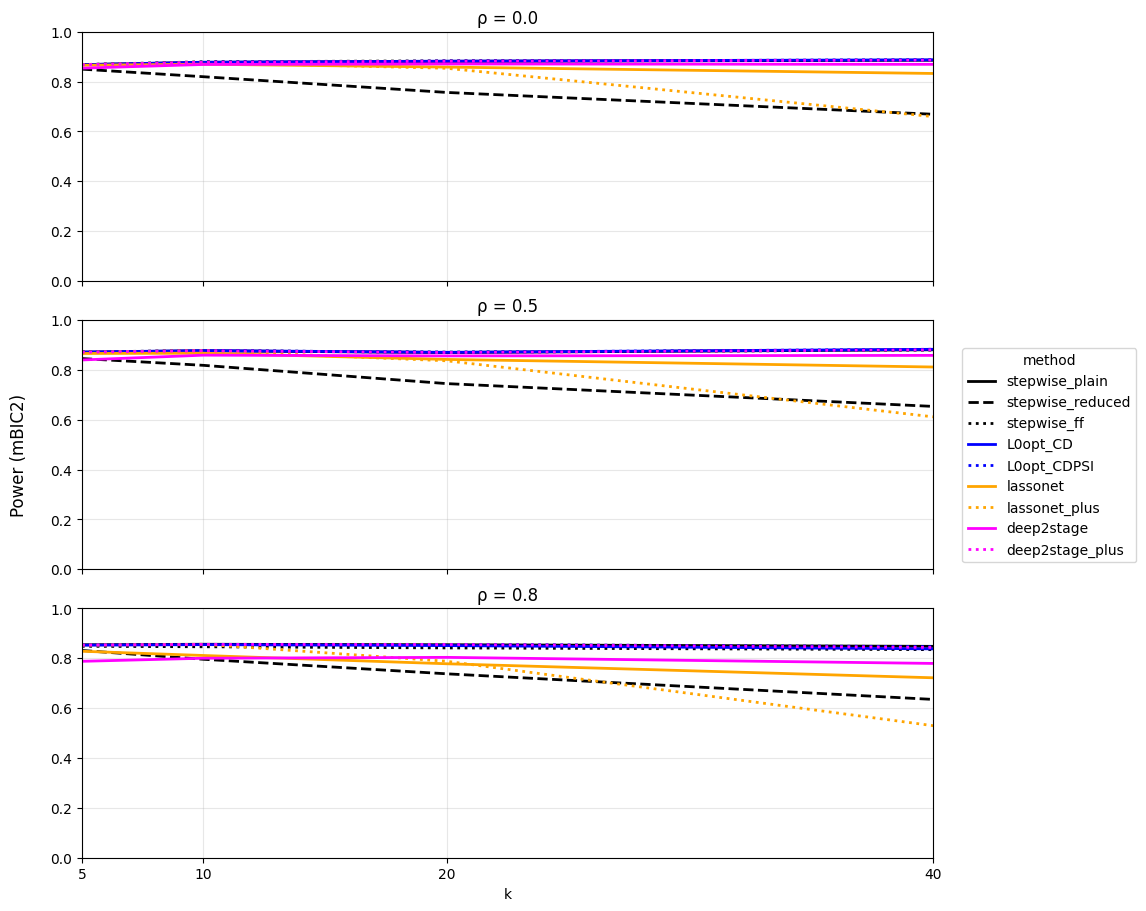

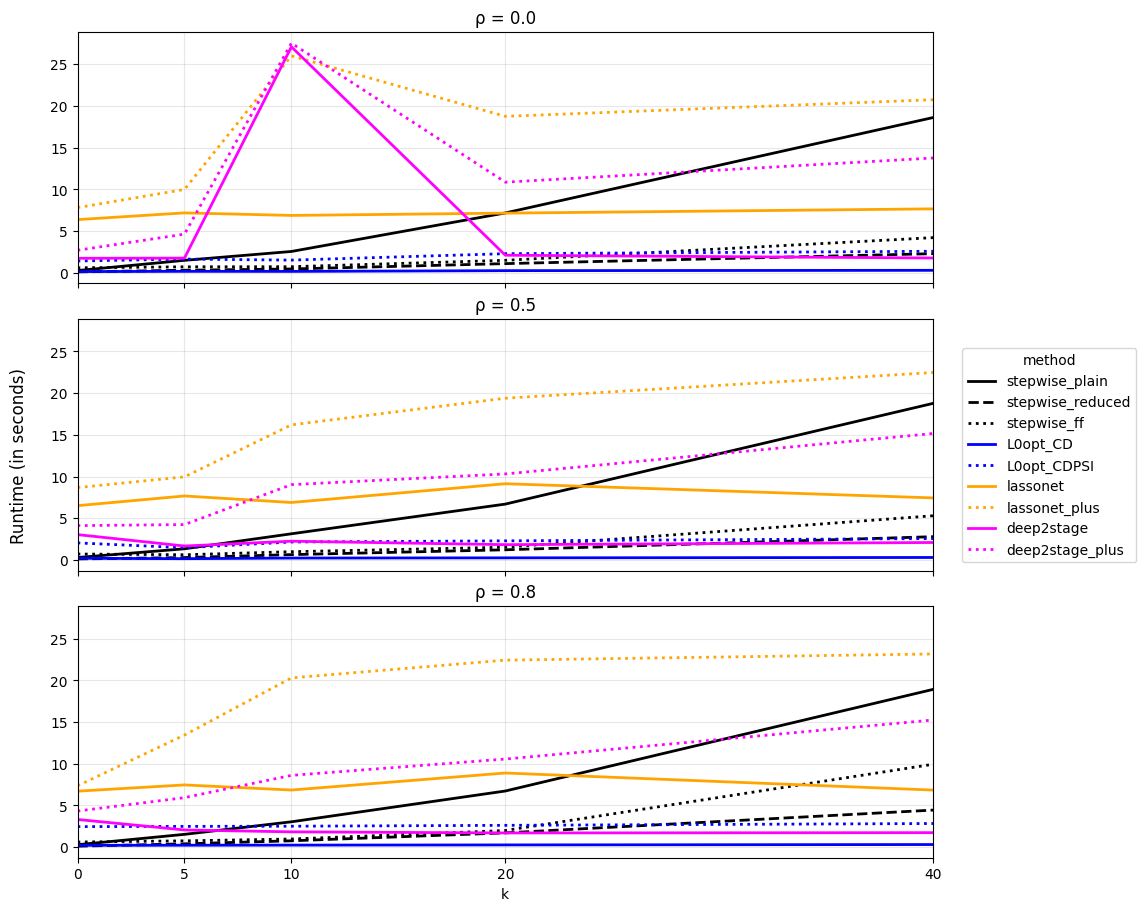

In [31]:
# FP (nur mBIC)
plot_metric_over_k(df, which='mBIC',  metric='FP',   ymax=3)

# FDR (nur mBIC2)
plot_metric_over_k(df, which='mBIC2', metric='FDR',  ymax=0.3)   # 0..1

# Power
plot_metric_over_k(df, which='mBIC',  metric='Power',  ymax=1.0)
plot_metric_over_k(df, which='mBIC2', metric='Power',  ymax=1.0)

# Runtime
plot_metric_over_k(df, which='mBIC',  metric='Runtime', ymax=None)  # z.B. automatisch

## Summary Tabellen

In [32]:
# =======================
# Summary Table
# =======================

def _overall_sum(df, value_col, drop_methods=None):
    tmp = df if drop_methods is None else df[~df['method'].isin(drop_methods)]
    s = tmp.groupby('method')[value_col].sum()
    cols = [m for m in method_order if m in s.index]
    return pd.DataFrame([s.reindex(cols).values], columns=cols)

def _overall_mean(df, value_col, drop_methods=None):
    tmp = df if drop_methods is None else df[~df['method'].isin(drop_methods)]
    s = tmp.groupby('method')[value_col].mean()
    cols = [m for m in method_order if m in s.index]
    return pd.DataFrame([s.reindex(cols).values], columns=cols)

# Hinweis: Wenn du die Baseline ausblenden willst:
# DROP = ['stepwise_plain']
DROP = None  # oder z.B. ['stepwise_plain']

# mBIC / mBIC2 subsets
df_mbic  = df[df["method"] == "mBIC"]
df_mbic2 = df[df["method"] == "mBIC2"]

overall_impr_mBIC   = _overall_sum(df, 'Better',  drop_methods=DROP)
overall_impr_mBIC2  = _overall_sum(df, 'Better2', drop_methods=DROP)
overall_worse_mBIC  = _overall_sum(df, 'Worse',   drop_methods=DROP)
overall_worse_mBIC2 = _overall_sum(df, 'Worse2',  drop_methods=DROP)


# Averages
overall_fp   = _overall_mean(df,        "FP",    drop_methods=DROP)    
overall_fdr  = _overall_mean(df,        "FDR2",  drop_methods=DROP)     
df_posk = df[df["k"] > 0]
overall_power_mBIC  = _overall_mean(df_posk, "Power",  drop_methods=DROP)   # mBIC
overall_power_mBIC2 = _overall_mean(df_posk, "Power2", drop_methods=DROP)   # mBIC2
overall_runtime_mBIC  = _overall_mean(df, "Runtime", drop_methods=DROP)

tables = [
    ("Total number of improvements (mBIC)",  overall_impr_mBIC),
    ("Total number of improvements (mBIC2)", overall_impr_mBIC2),
    ("Total number of worsenings (mBIC)",    overall_worse_mBIC),
    ("Total number of worsenings (mBIC2)",   overall_worse_mBIC2),
    ("Average False Positives (mBIC)", overall_fp),
    ("Average FDR (mBIC2)",            overall_fdr),
    ("Average Power (mBIC)",  overall_power_mBIC),
    ("Average Power (mBIC2)", overall_power_mBIC2),
    ("Average Runtime",  overall_runtime_mBIC),
]

for title, tbl in tables:
    _display_tbl(title, tbl)

,stepwise_plain,stepwise_reduced,stepwise_ff,L0opt_CD,L0opt_CDPSI,lassonet,lassonet_plus,deep2stage,deep2stage_plus
0,0,1,109,82,173,7,11,22,157


,stepwise_plain,stepwise_reduced,stepwise_ff,L0opt_CD,L0opt_CDPSI,lassonet,lassonet_plus,deep2stage,deep2stage_plus
0,0,1,269,345,493,10,22,20,257


,stepwise_plain,stepwise_reduced,stepwise_ff,L0opt_CD,L0opt_CDPSI,lassonet,lassonet_plus,deep2stage,deep2stage_plus
0,0,3556,548,376,241,2754,2371,3616,186


,stepwise_plain,stepwise_reduced,stepwise_ff,L0opt_CD,L0opt_CDPSI,lassonet,lassonet_plus,deep2stage,deep2stage_plus
0,0,4019,960,668,510,3751,2523,4332,578


,stepwise_plain,stepwise_reduced,stepwise_ff,L0opt_CD,L0opt_CDPSI,lassonet,lassonet_plus,deep2stage,deep2stage_plus
0,0.13,0.29,0.18,0.16,0.13,0.72,0.08,0.43,0.13


,stepwise_plain,stepwise_reduced,stepwise_ff,L0opt_CD,L0opt_CDPSI,lassonet,lassonet_plus,deep2stage,deep2stage_plus
0,0.05,0.04,0.06,0.05,0.05,0.06,0.03,0.05,0.05


,stepwise_plain,stepwise_reduced,stepwise_ff,L0opt_CD,L0opt_CDPSI,lassonet,lassonet_plus,deep2stage,deep2stage_plus
0,0.84,0.75,0.84,0.84,0.85,0.81,0.74,0.82,0.85


,stepwise_plain,stepwise_reduced,stepwise_ff,L0opt_CD,L0opt_CDPSI,lassonet,lassonet_plus,deep2stage,deep2stage_plus
0,0.87,0.76,0.87,0.87,0.87,0.83,0.79,0.84,0.87


,stepwise_plain,stepwise_reduced,stepwise_ff,L0opt_CD,L0opt_CDPSI,lassonet,lassonet_plus,deep2stage,deep2stage_plus
0,6.05,1.11,2.08,0.23,2.19,7.31,16.44,3.73,9.80


## Distribution of mBIC values, mBIC2, runtime

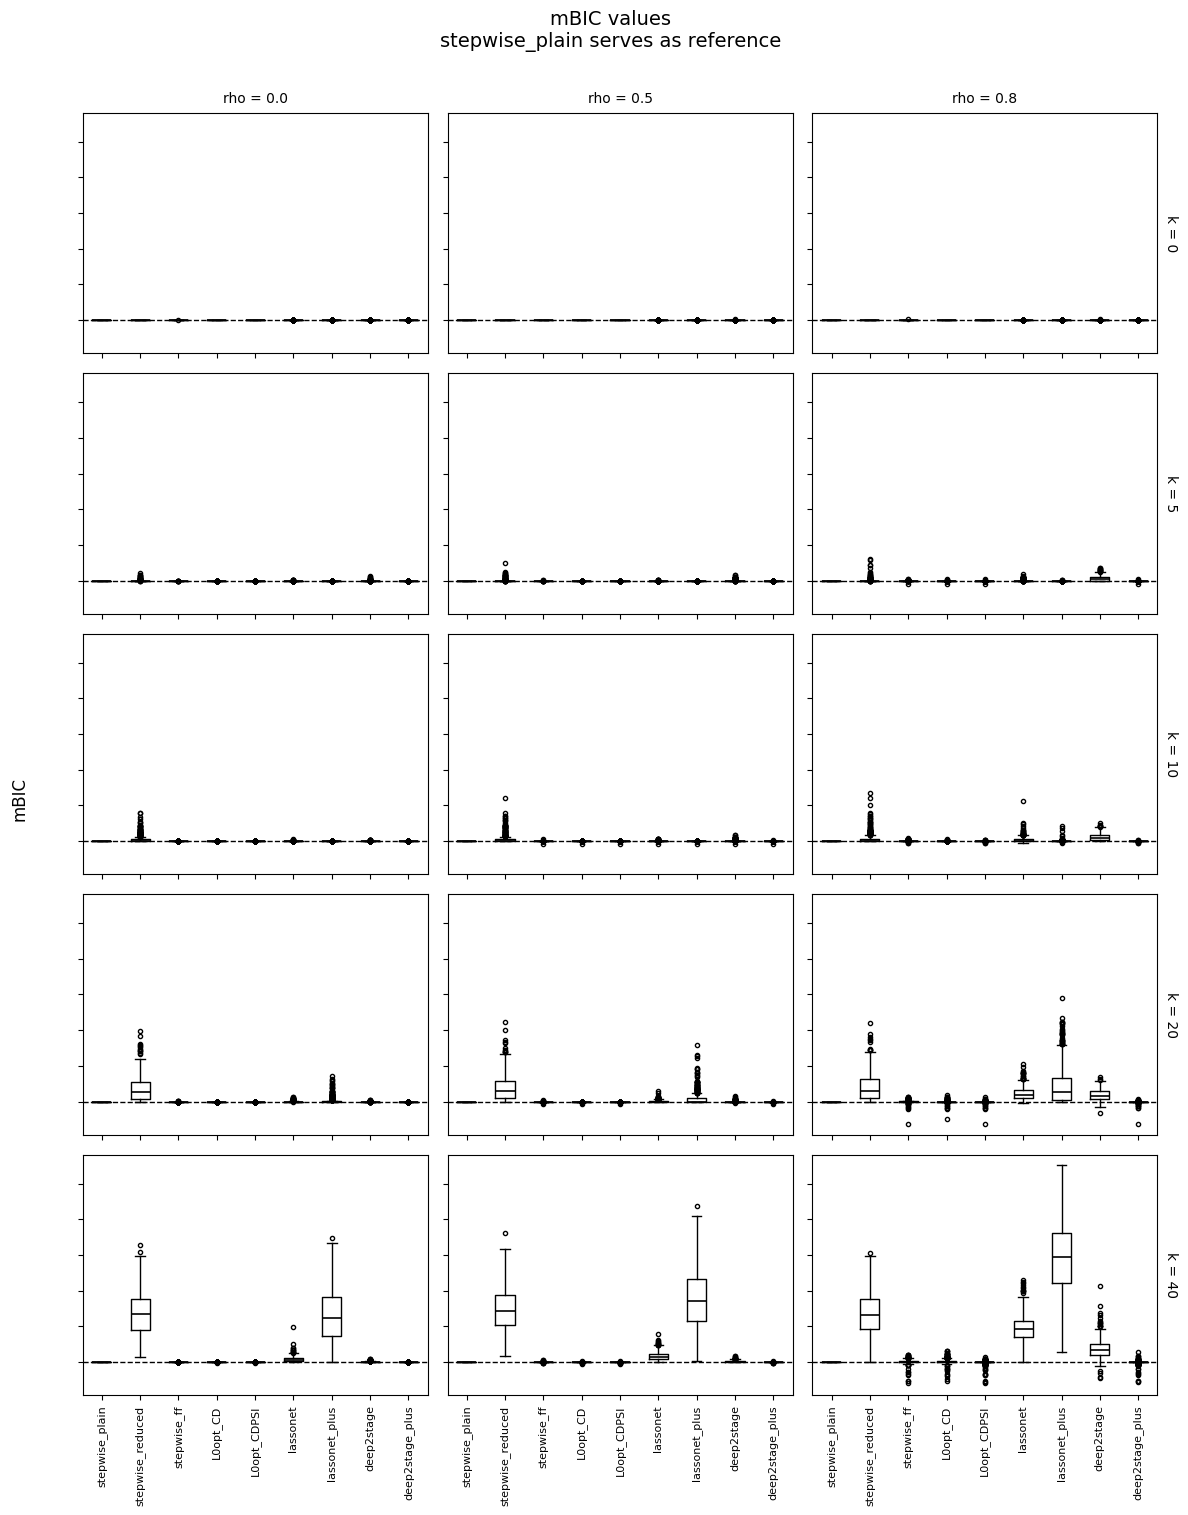

In [33]:
k_vals   = sorted(pd.unique(df_mBIC["k"]))
rho_vals = sorted(pd.unique(df_mBIC["rho"]))
nrows, ncols = len(k_vals), len(rho_vals)

fig, axes = plt.subplots(nrows=nrows, ncols=ncols,
                         figsize=(4.4*ncols, 3.8*nrows),
                         sharey=True)

# axes als 2D-Array normalisieren
if nrows == 1 and ncols == 1:
    axes = np.array([[axes]])
elif nrows == 1:
    axes = axes.reshape(1, -1)
elif ncols == 1:
    axes = axes.reshape(-1, 1)

# --- Boxplots ---
for i, k in enumerate(k_vals):
    for j, rho in enumerate(rho_vals):
        ax = axes[i, j]
        sub = df_mBIC[(df_mBIC["k"] == k) & (df_mBIC["rho"] == rho)]
        data_by_method = [sub.loc[sub["variable"] == m, "mBIC"].dropna().values
                          for m in method_order]

        ax.boxplot(
            data_by_method,
            tick_labels=method_order,           # Matplotlib ≥3.9: tick_labels
            showmeans=False,
            showfliers=True,
            patch_artist=False,                 # S/W (keine Füllung)
            medianprops=dict(color="black", linewidth=1.2),
            whiskerprops=dict(color="black", linewidth=1.0),
            capprops=dict(color="black", linewidth=1.0),
            boxprops=dict(color="black", linewidth=1.0),
            flierprops=dict(marker='o', markersize=3, markerfacecolor='none',
                            markeredgecolor='black', linewidth=0.6),
        )

        ax.axhline(0.0, linestyle="--", linewidth=1.0, color="black")

        # X-Ticks: nur unten – vertikal
        if i < nrows - 1:
            ax.set_xticklabels([])
        else:
            for tick in ax.get_xticklabels():
                tick.set_rotation(90)
                tick.set_ha("center")
                tick.set_va("top")
                tick.set_fontsize(8)

        # Y-Ticks nur links
        if j > 0:
            ax.set_yticklabels([])

        ax.set_title("")

# --- ρ pro Spalte (nah an die Subplots) ---
for j, rho in enumerate(rho_vals):
    top_ax = axes[0, j]
    top_ax.text(0.5, 1.03, f"rho = {rho:.1f}",
                ha="center", va="bottom", fontsize=10,
                transform=top_ax.transAxes)

# --- k pro Zeile (rechts, 180° gedreht, mit etwas Abstand) ---
for i, k in enumerate(k_vals):
    right_ax = axes[i, -1]
    right_ax.text(1.04, 0.5, f"k = {int(k) if float(k).is_integer() else k}",
                  ha="center", va="center",
                  rotation=270, fontsize=10,
                  transform=right_ax.transAxes)


fig.suptitle("mBIC values\nstepwise_plain serves as reference", fontsize=14, y=0.915)
fig.supylabel("mBIC", x=0.045)
plt.tight_layout(rect=[0.06, 0.12, 0.94, 0.91])


out_base = os.path.join(PREP_DIR, "Simu1_mBIC_boxplots")
out_pdf  = out_base + ".pdf"
plt.show()

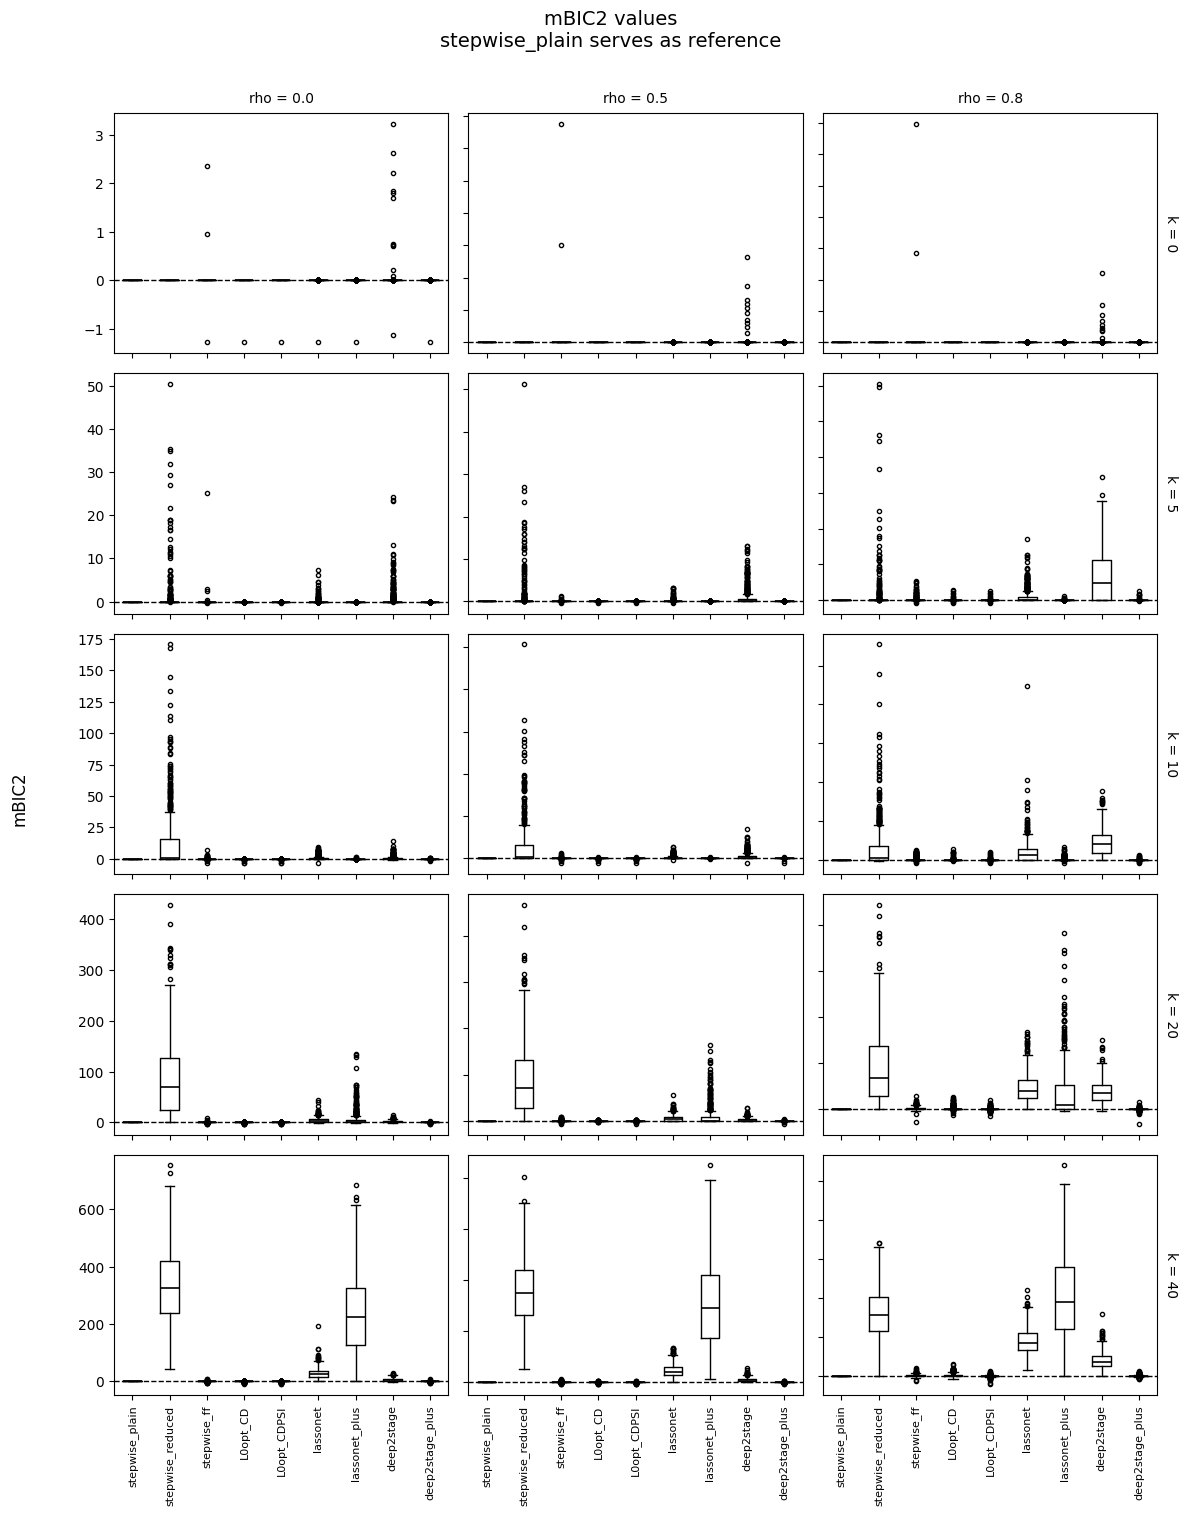

Gespeichert als: Results1_neu/Prepared1/Simu1_mBIC2_boxplots.pdf


In [34]:
k_vals   = sorted(pd.unique(df_mBIC2["k"]))
rho_vals = sorted(pd.unique(df_mBIC2["rho"]))
nrows, ncols = len(k_vals), len(rho_vals)

fig, axes = plt.subplots(nrows=nrows, ncols=ncols,
                         figsize=(4.4*ncols, 3.8*nrows),
                         sharey=False)

# axes als 2D-Array normalisieren
if nrows == 1 and ncols == 1:
    axes = np.array([[axes]])
elif nrows == 1:
    axes = axes.reshape(1, -1)
elif ncols == 1:
    axes = axes.reshape(-1, 1)

# --- Boxplots ---
for i, k in enumerate(k_vals):
    for j, rho in enumerate(rho_vals):
        ax = axes[i, j]
        sub = df_mBIC2[(df_mBIC2["k"] == k) & (df_mBIC2["rho"] == rho)]
        data_by_method = [sub.loc[sub["variable"] == m, "mBIC2"].dropna().values
                          for m in method_order]

        ax.boxplot(
            data_by_method,
            tick_labels=method_order,           # Matplotlib ≥3.9: tick_labels
            showmeans=False,
            showfliers=True,
            patch_artist=False,                 # S/W (keine Füllung)
            medianprops=dict(color="black", linewidth=1.2),
            whiskerprops=dict(color="black", linewidth=1.0),
            capprops=dict(color="black", linewidth=1.0),
            boxprops=dict(color="black", linewidth=1.0),
            flierprops=dict(marker='o', markersize=3, markerfacecolor='none',
                            markeredgecolor='black', linewidth=0.6),
        )

        ax.axhline(0.0, linestyle="--", linewidth=1.0, color="black")

        # X-Ticks: nur unten – vertikal
        if i < nrows - 1:
            ax.set_xticklabels([])
        else:
            for tick in ax.get_xticklabels():
                tick.set_rotation(90)
                tick.set_ha("center")
                tick.set_va("top")
                tick.set_fontsize(8)

        # Y-Ticks nur links
        if j > 0:
            ax.set_yticklabels([])

        ax.set_title("")

# --- ρ pro Spalte (nah an die Subplots) ---
for j, rho in enumerate(rho_vals):
    top_ax = axes[0, j]
    top_ax.text(0.5, 1.03, f"rho = {rho:.1f}",
                ha="center", va="bottom", fontsize=10,
                transform=top_ax.transAxes)

# --- k pro Zeile (rechts, 270° gedreht, mit etwas Abstand) ---
for i, k in enumerate(k_vals):
    right_ax = axes[i, -1]
    right_ax.text(1.04, 0.5, f"k = {int(k) if float(k).is_integer() else k}",
                  ha="center", va="center",
                  rotation=270, fontsize=10,
                  transform=right_ax.transAxes)

fig.suptitle("mBIC2 values\nstepwise_plain serves as reference", fontsize=14, y=0.915)
fig.supylabel("mBIC2", x=0.045)
plt.tight_layout(rect=[0.06, 0.12, 0.94, 0.91])

out_base = os.path.join(PREP_DIR, "Simu1_mBIC2_boxplots")
out_pdf  = out_base + ".pdf"
plt.savefig(out_pdf, bbox_inches="tight")
plt.show()
print("Gespeichert als:", out_pdf)

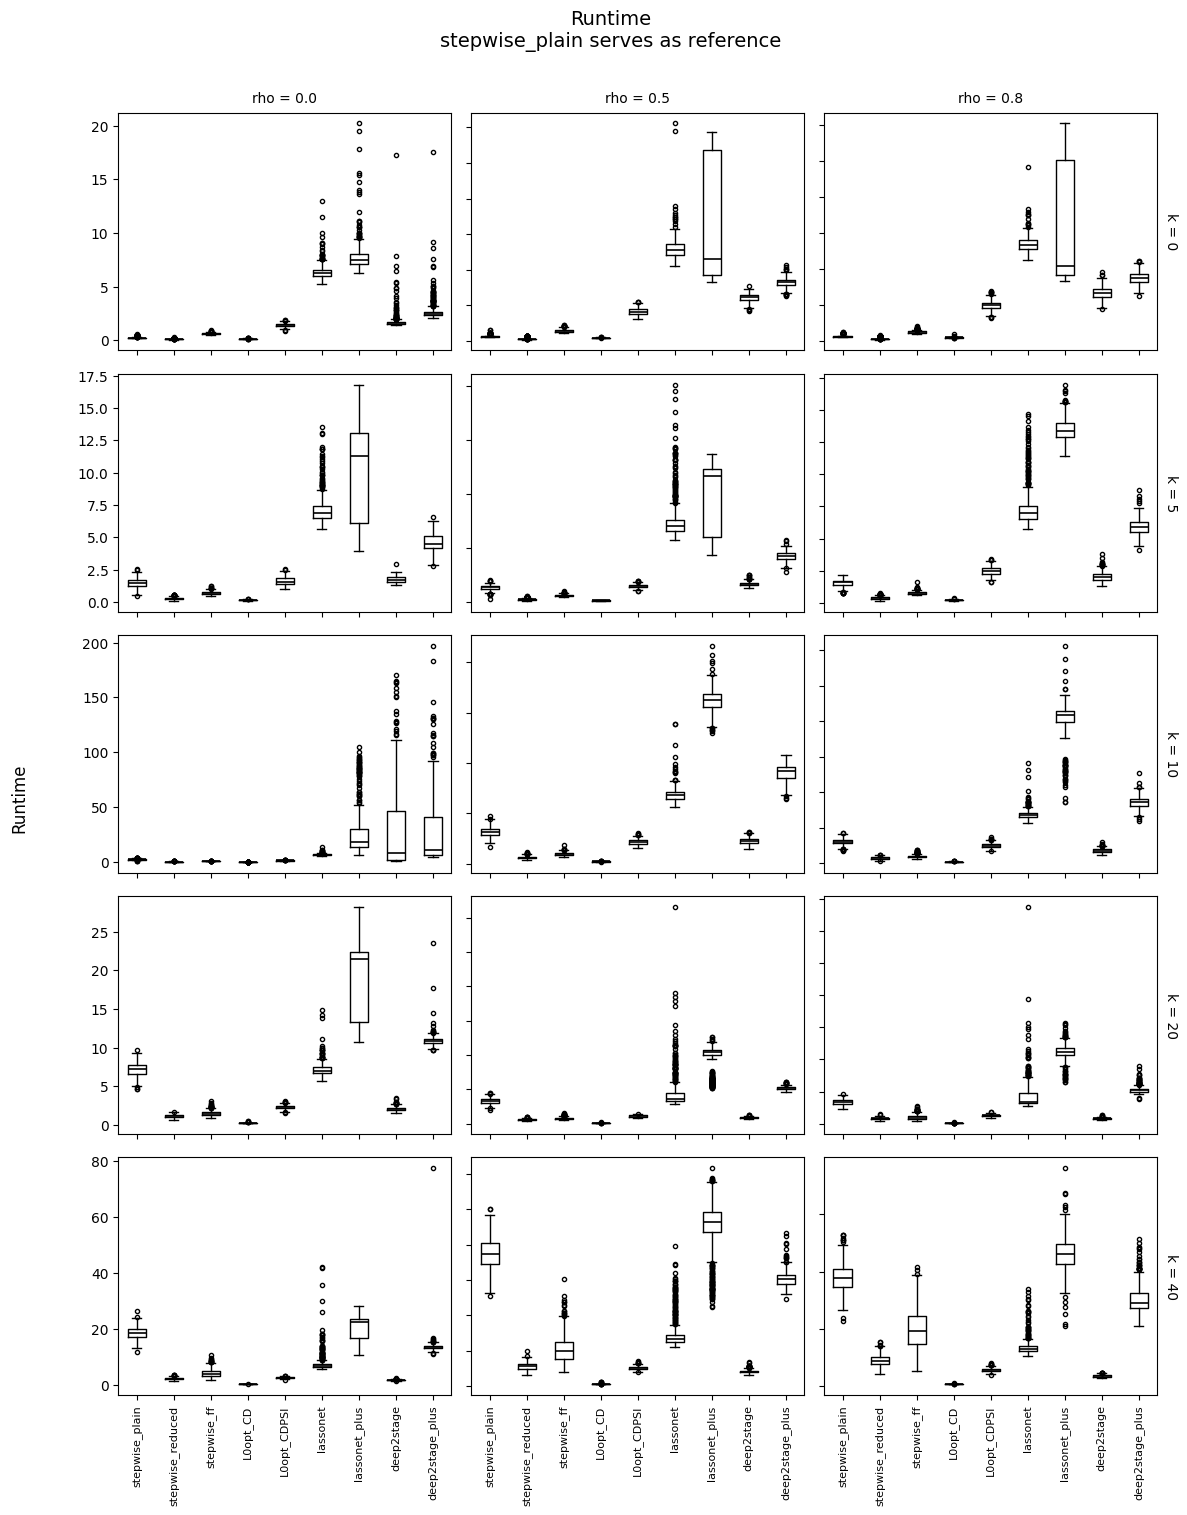

In [36]:
k_vals   = sorted(pd.unique(df_Runtime["k"]))
rho_vals = sorted(pd.unique(df_Runtime["rho"]))
nrows, ncols = len(k_vals), len(rho_vals)

fig, axes = plt.subplots(nrows=nrows, ncols=ncols,
                         figsize=(4.4*ncols, 3.8*nrows),
                         sharey=False)

# axes als 2D-Array normalisieren
if nrows == 1 and ncols == 1:
    axes = np.array([[axes]])
elif nrows == 1:
    axes = axes.reshape(1, -1)
elif ncols == 1:
    axes = axes.reshape(-1, 1)

# --- Boxplots (Runtime) ---
for i, k in enumerate(k_vals):
    for j, rho in enumerate(rho_vals):
        ax = axes[i, j]
        sub = df_Runtime[(df_Runtime["k"] == k) & (df_Runtime["rho"] == rho)]
        data_by_method = [sub.loc[sub["variable"] == m, "Runtime"].dropna().values
                          for m in method_order]

        ax.boxplot(
            data_by_method,
            tick_labels=method_order,           # Matplotlib ≥3.9: tick_labels
            showmeans=False,
            showfliers=True,
            patch_artist=False,                 # S/W (keine Füllung)
            medianprops=dict(color="black", linewidth=1.2),
            whiskerprops=dict(color="black", linewidth=1.0),
            capprops=dict(color="black", linewidth=1.0),
            boxprops=dict(color="black", linewidth=1.0),
            flierprops=dict(marker='o', markersize=3, markerfacecolor='none',
                            markeredgecolor='black', linewidth=0.6),
        )

        # X-Ticks: nur unten – vertikal
        if i < nrows - 1:
            ax.set_xticklabels([])
        else:
            for tick in ax.get_xticklabels():
                tick.set_rotation(90)
                tick.set_ha("center")
                tick.set_va("top")
                tick.set_fontsize(8)

        # Y-Ticks nur links
        if j > 0:
            ax.set_yticklabels([])

        ax.set_title("")

# --- ρ pro Spalte (nah an die Subplots) ---
for j, rho in enumerate(rho_vals):
    top_ax = axes[0, j]
    top_ax.text(0.5, 1.03, f"rho = {rho:.1f}",
                ha="center", va="bottom", fontsize=10,
                transform=top_ax.transAxes)

# --- k pro Zeile (rechts, 270° gedreht, mit etwas Abstand) ---
for i, k in enumerate(k_vals):
    right_ax = axes[i, -1]
    right_ax.text(1.04, 0.5, f"k = {int(k) if float(k).is_integer() else k}",
                  ha="center", va="center",
                  rotation=270, fontsize=10,
                  transform=right_ax.transAxes)

# Titel näher an die Subplots
fig.suptitle("Runtime\nstepwise_plain serves as reference", fontsize=14, y=0.915)

# Gemeinsames Y-Label
fig.supylabel("Runtime", x=0.045)

# Platz für rho (oben) und k (rechts) lassen
plt.tight_layout(rect=[0.06, 0.12, 0.94, 0.91])


out_base = os.path.join(PREP_DIR, "Simu1_Runtime_boxplots")
out_pdf  = out_base + ".pdf"
plt.show()